In [1]:
import os
from os.path import exists, join

import matplotlib.animation as animation
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tifffile import imread, imwrite
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
um_per_pixel = 0.117
s_per_frame = 2
folder_data = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\HOPS_Microtubule_dual imaging_SiR_Tubulin\Analysed data\For_montage"
folder_save = folder_data

tif_filename = "C1_C2_Merged_20241031_UGD_HOPS_MT_SiR-Tubulin_2x_exp500ms_rep3_FOV-2-right-bandpass_crop2.tif"
csv_filename = "20241031_UGD_HOPS_MT_SiR-Tubulin_2x_rep3_FOV-2-right-bandpass_spots_crop2-wstepflags.csv"

os.chdir(folder_data)
video = imread(tif_filename)
print("Shape of video array:", video.shape)
df = pd.read_csv(csv_filename)
df = df.sort_values("t")

plow = 0.5  # imshow intensity percentile
phigh = 90
scalebar_color = "white"

cmap_blue = clr.LinearSegmentedColormap.from_list(
    "dark2blue",
    ["black", "#00FF00"],
)
cmap_red = clr.LinearSegmentedColormap.from_list(
    "transparent2red",
    [(0.753, 0.22, 0.188, 0), (0.753, 0.22, 0.188, 1)],
)

scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um / um_per_pixel
scale_bar_offset = 1
aspect_width = 37
aspect_height = 19
scaling_factor = 0.5
fig_width = aspect_width * scaling_factor
fig_height = aspect_height * scaling_factor
fig, ax = plt.subplots(1, 1)
# fig, ax = plt.subplots(figsize=(fig_width, fig_height))
all_avaliable_frames = set(df["t"].unique())

def find_true_transitions(bool_array):
    ranges = []
    n = len(bool_array)
    i = 0
    while i < n:
        if bool_array[i]:
            start = i - 1 if i > 0 else i  # Include previous point if not at the start
            while i < n and bool_array[i]:
                i += 1
            end = i - 1
            ranges.append((start, end))
        else:
            i += 1
    return ranges

# Colors for paths
unflagged_color = "dodgerblue"
flagged_color = "#dca800"

def animate(frame):
    ax.clear()
    img_red = video[frame - 1, 0, :, :]
    img_blue = video[frame - 1, 1, :, :]
    plt.imshow(
        img_blue,
        cmap=cmap_blue,
        vmin=20,
        vmax=60,
    )
    plt.imshow(
        img_red,
        cmap=cmap_red,
        vmin=20000,
        vmax=52000,
    )

    # Define parameters for ensuring square output
    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)

    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2

    x_min, x_max = x_center - max_range / 2, x_center + max_range / 2
    y_min, y_max = y_center - max_range / 2, y_center + max_range / 2
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', 'box')
    ax.invert_yaxis()
    ax.axis("off")

    # Add time stamp
    plt.text(
        15.2,
        1,
        str(round(frame * s_per_frame, 2)) + "s",
        color="white",
        weight="bold",
        size=18,
    )
    # Add color labels
    plt.text(
        0,
        16,
        "MT",
        color="#eb4034",
        weight="bold",
        size=18,
    )
    plt.text(
        0,
        17.5,
        "HOPS",
        color="#00FF00",
        weight="bold",
        size=18,
    )

    # Add a single current circle, except for gaps
    # if frame - 1 in all_avaliable_frames:
    #     current_x = df[df["t"] == frame - 1]["x"].squeeze()
    #     current_y = df[df["t"] == frame - 1]["y"].squeeze()
    #     circle_radius = 1.3
    #     white_circle = plt.Circle(
    #         (current_x, current_y),
    #         circle_radius,
    #         color="white",
    #         fill=False,
    #         lw=2,
    #     )
    #     ax.add_patch(white_circle)

    current_data = df[df["t"] == (frame - 1)]
    # print(f"Frame {frame - 1}: {len(current_data)} circles to draw")
    for _, row in current_data.iterrows():
        current_x = row["x"]
        current_y = row["y"]
        circle_radius = 1.3
        white_circle = plt.Circle(
            (current_x, current_y),
            circle_radius,
            color="white",
            fill=False,
            lw=2,
        )
        ax.add_patch(white_circle)
    # Add a trajectory track
    track = df[df["t"] <= frame - 1]
    if not track.empty:
        x_plot = track["x"].to_numpy(float)
        y_plot = track["y"].to_numpy(float)
        flags = track["step_flag"].to_numpy(bool)
        last_end = -1
        true_ranges = find_true_transitions(flags)

        for start, end in true_ranges:
                # Plot segments before the true range
                if start > last_end + 1:
                    plt.plot(
                        x_plot[last_end + 1:start + 1],
                        y_plot[last_end + 1:start + 1],
                        "-o",
                        color=unflagged_color,
                        lw=2,
                        markersize=4
                    )
                
                # Plot the true range
                plt.plot(
                    x_plot[start:end + 1],
                    y_plot[start:end + 1],
                    "-o",
                    color=flagged_color,
                    lw=2,
                    markersize=4,
                )
                
                last_end = end
        try:
            idx_125 = track[track["t"] == 125].index[0]
            idx_126 = track[track["t"] == 126].index[0]
            plt.plot(
                x_plot[idx_125:idx_126 + 1],
                y_plot[idx_125:idx_126 + 1],
                "-o",
                color=unflagged_color,
                lw=2,
                markersize=4
            )

        except IndexError:
            pass
        
        # Plot remaining unflagged segments after the last true range
        if last_end + 1 < len(x_plot):
            plt.plot(
                x_plot[last_end + 2:],
                y_plot[last_end + 2:],
                "-o",
                color=unflagged_color,
                lw=2,
                markersize=4
            )

            plt.plot(
                x_plot[last_end + 1:],
                y_plot[last_end + 1:],
                "-o",
                color=unflagged_color,
                lw=2,
                markersize=4
            )

    # Scale bar
    scale_bar_offset = 0
    base_x = 9.3
    base_y = 17.5
    scalebar_length_pxl = scalebar_length_um / um_per_pixel
    plt.plot(
        [
            base_x + scale_bar_offset,
            base_x + scale_bar_offset + scalebar_length_pxl,
        ],
        [base_y + scale_bar_offset, base_y + scale_bar_offset],
        "-",
        color="white",
        lw=5,
    )
    plt.xlim(0, img_blue.shape[0])
    plt.ylim(img_blue.shape[1], 0)
    plt.tight_layout()
    plt.axis("scaled")
    plt.axis("off")

# Create montage images
num_frames = 200
for frame in range(1, num_frames + 1):
    animate(frame)
    plt.savefig(join(folder_save, f"frame_{frame:03d}.png"), dpi=600, bbox_inches='tight')
    # plt.show()

plt.close(fig)

# Create animated video
# ani = FuncAnimation(fig, animate, frames=200, interval=20, repeat=False)
# writer = animation.FFMpegWriter(fps=20)  # 20 Hz
# ani.save(join(folder_save, "VideoS_HOPS_hopping_MT.mp4"), writer=writer, dpi=600)

Shape of video array: (200, 2, 19, 19)


## Without any labels

In [4]:
import os
from os.path import exists, join

import matplotlib.animation as animation
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tifffile import imread, imwrite
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

pd.options.mode.chained_assignment = None  # default='warn'

um_per_pixel = 0.117
s_per_frame = 2
folder_data = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\HOPS_Microtubule_dual imaging_SiR_Tubulin\Analysed data\For_montage"
folder_save = folder_data

tif_filename = "C1_C2_Merged_20241031_UGD_HOPS_MT_SiR-Tubulin_2x_exp500ms_rep3_FOV-2-right-bandpass_crop2.tif"
csv_filename = "20241031_UGD_HOPS_MT_SiR-Tubulin_2x_rep3_FOV-2-right-bandpass_spots_crop2-wstepflags.csv"

os.chdir(folder_data)
video = imread(tif_filename)
print("Shape of video array:", video.shape)
df = pd.read_csv(csv_filename)
df = df.sort_values("t")

plow = 0.5  # imshow intensity percentile
phigh = 90
scalebar_color = "white"

cmap_blue = clr.LinearSegmentedColormap.from_list(
    "dark2blue",
    ["black", "#00FF00"],
)
cmap_red = clr.LinearSegmentedColormap.from_list(
    "transparent2red",
    [(0.753, 0.22, 0.188, 0), (0.753, 0.22, 0.188, 1)],
)

scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um / um_per_pixel
scale_bar_offset = 1
aspect_width = 37
aspect_height = 19
scaling_factor = 0.5
fig_width = aspect_width * scaling_factor
fig_height = aspect_height * scaling_factor
fig, ax = plt.subplots(1, 1)
# fig, ax = plt.subplots(figsize=(fig_width, fig_height))
all_avaliable_frames = set(df["t"].unique())

def find_true_transitions(bool_array):
    ranges = []
    n = len(bool_array)
    i = 0
    while i < n:
        if bool_array[i]:
            start = i - 1 if i > 0 else i  # Include previous point if not at the start
            while i < n and bool_array[i]:
                i += 1
            end = i - 1
            ranges.append((start, end))
        else:
            i += 1
    return ranges

# Colors for paths
unflagged_color = "dodgerblue"
flagged_color = "#dca800"

def animate(frame):
    ax.clear()
    img_red = video[frame - 1, 0, :, :]
    img_blue = video[frame - 1, 1, :, :]
    plt.imshow(
        img_blue,
        cmap=cmap_blue,
        vmin=20,
        vmax=60,
    )
    plt.imshow(
        img_red,
        cmap=cmap_red,
        vmin=20000,
        vmax=52000,
    )

    # Define parameters for ensuring square output
    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)

    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2

    x_min, x_max = x_center - max_range / 2, x_center + max_range / 2
    y_min, y_max = y_center - max_range / 2, y_center + max_range / 2
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', 'box')
    ax.invert_yaxis()
    ax.axis("off")

    # Add time stamp
    # plt.text(
    #     15.2,
    #     1,
    #     str(round(frame * s_per_frame, 2)) + "s",
    #     color="white",
    #     weight="bold",
    #     size=18,
    # )
    # Add color labels
    # plt.text(
    #     0,
    #     16,
    #     "MT",
    #     color="#eb4034",
    #     weight="bold",
    #     size=18,
    # )
    # plt.text(
    #     0,
    #     17.5,
    #     "HOPS",
    #     color="#00FF00",
    #     weight="bold",
    #     size=18,
    # )

    # Add a single current circle, except for gaps
    # if frame - 1 in all_avaliable_frames:
    #     current_x = df[df["t"] == frame - 1]["x"].squeeze()
    #     current_y = df[df["t"] == frame - 1]["y"].squeeze()
    #     circle_radius = 1.3
    #     white_circle = plt.Circle(
    #         (current_x, current_y),
    #         circle_radius,
    #         color="white",
    #         fill=False,
    #         lw=2,
    #     )
    #     ax.add_patch(white_circle)

    current_data = df[df["t"] == (frame - 1)]
    # print(f"Frame {frame - 1}: {len(current_data)} circles to draw")
    for _, row in current_data.iterrows():
        current_x = row["x"]
        current_y = row["y"]
        circle_radius = 1.3
        white_circle = plt.Circle(
            (current_x, current_y),
            circle_radius,
            color="white",
            fill=False,
            lw=2,
        )
        ax.add_patch(white_circle)
    # Add a trajectory track
    track = df[df["t"] <= frame - 1]
    if not track.empty:
        x_plot = track["x"].to_numpy(float)
        y_plot = track["y"].to_numpy(float)
        flags = track["step_flag"].to_numpy(bool)
        last_end = -1
        true_ranges = find_true_transitions(flags)

        for start, end in true_ranges:
                # Plot segments before the true range
                if start > last_end + 1:
                    plt.plot(
                        x_plot[last_end + 1:start + 1],
                        y_plot[last_end + 1:start + 1],
                        "-o",
                        color=unflagged_color,
                        lw=2,
                        markersize=4
                    )
                
                # Plot the true range
                plt.plot(
                    x_plot[start:end + 1],
                    y_plot[start:end + 1],
                    "-o",
                    color=flagged_color,
                    lw=2,
                    markersize=4,
                )
                
                last_end = end
        try:
            idx_125 = track[track["t"] == 125].index[0]
            idx_126 = track[track["t"] == 126].index[0]
            plt.plot(
                x_plot[idx_125:idx_126 + 1],
                y_plot[idx_125:idx_126 + 1],
                "-o",
                color=unflagged_color,
                lw=2,
                markersize=4
            )

        except IndexError:
            pass
        
        # Plot remaining unflagged segments after the last true range
        if last_end + 1 < len(x_plot):
            plt.plot(
                x_plot[last_end + 2:],
                y_plot[last_end + 2:],
                "-o",
                color=unflagged_color,
                lw=2,
                markersize=4
            )

            plt.plot(
                x_plot[last_end + 1:],
                y_plot[last_end + 1:],
                "-o",
                color=unflagged_color,
                lw=2,
                markersize=4
            )

    # Scale bar
    scale_bar_offset = 0
    base_x = 9.3
    base_y = 17.5
    scalebar_length_pxl = scalebar_length_um / um_per_pixel
    plt.plot(
        [
            base_x + scale_bar_offset,
            base_x + scale_bar_offset + scalebar_length_pxl,
        ],
        [base_y + scale_bar_offset, base_y + scale_bar_offset],
        "-",
        color="white",
        lw=5,
    )
    plt.xlim(0, img_blue.shape[0])
    plt.ylim(img_blue.shape[1], 0)
    plt.tight_layout()
    plt.axis("scaled")
    plt.axis("off")

# Create montage images
num_frames = 200
for frame in range(1, num_frames + 1):
    animate(frame)
    plt.savefig(join(folder_save, f"frame_{frame:03d}.png"), dpi=600, bbox_inches='tight')
    # plt.show()

plt.close(fig)

# Create animated video
# ani = FuncAnimation(fig, animate, frames=200, interval=20, repeat=False)
# writer = animation.FFMpegWriter(fps=20)  # 20 Hz
# ani.save(join(folder_save, "VideoS_HOPS_hopping_MT.mp4"), writer=writer, dpi=600)

Shape of video array: (200, 2, 19, 19)


Shape of video array: (200, 2, 19, 37)


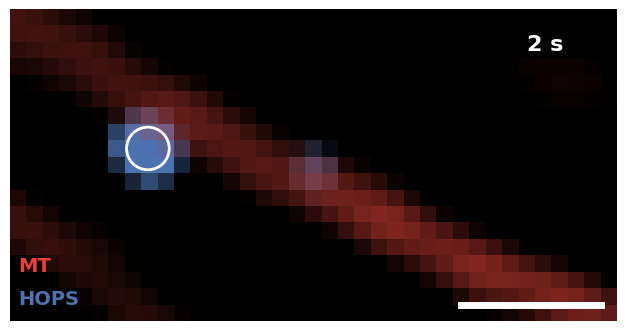

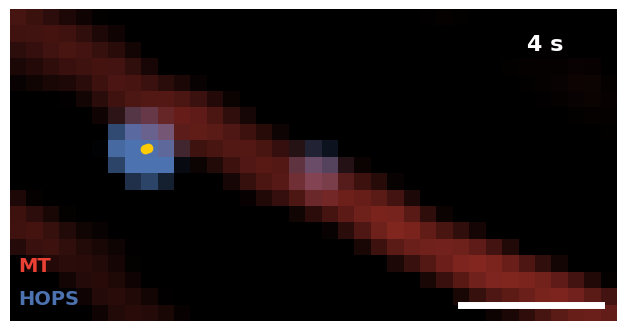

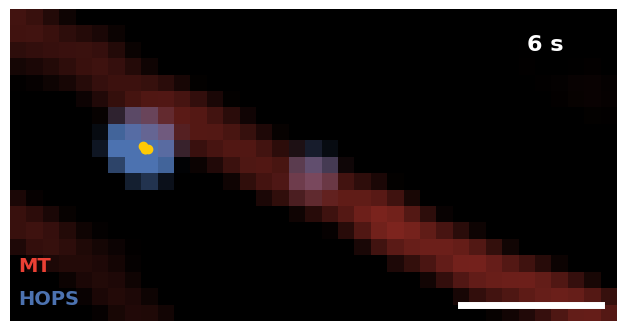

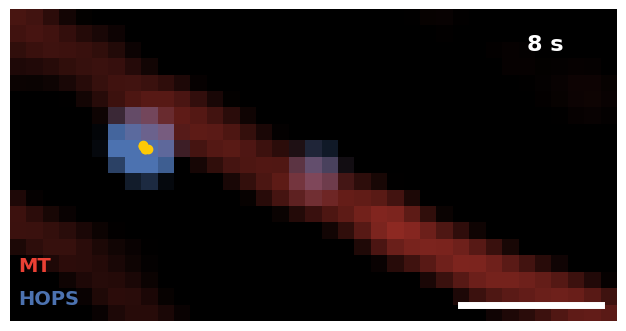

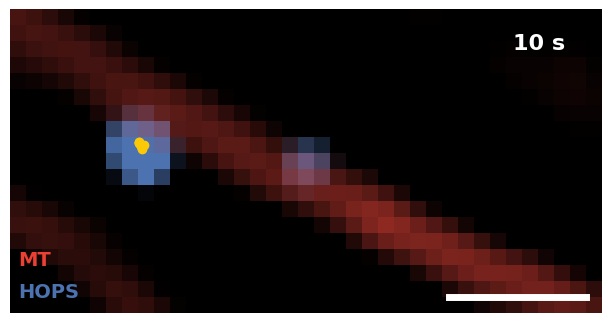

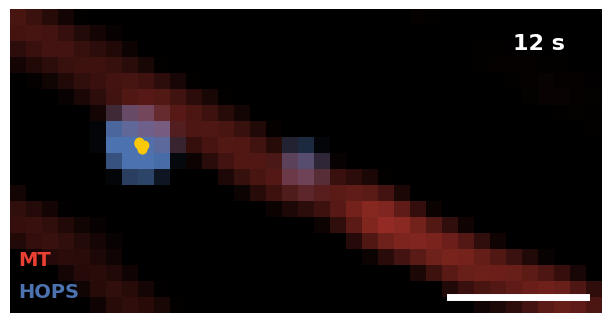

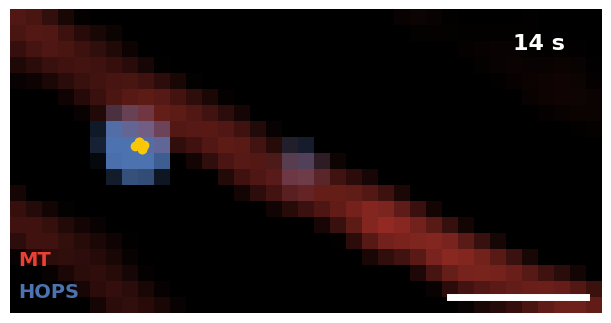

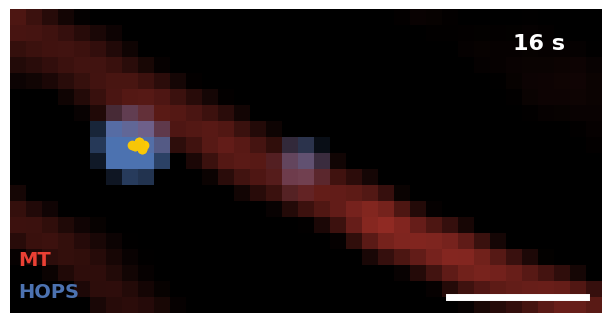

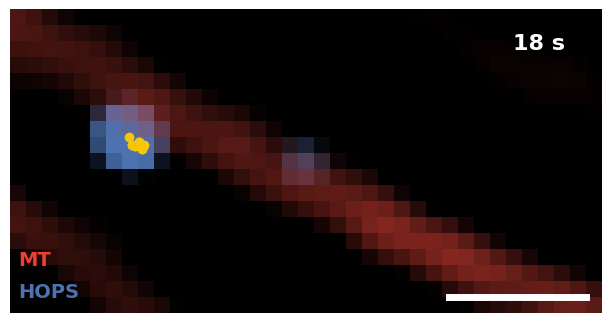

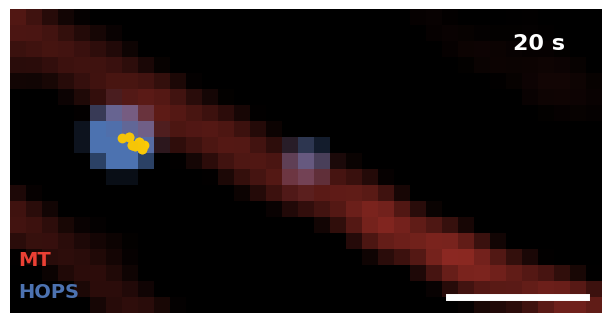

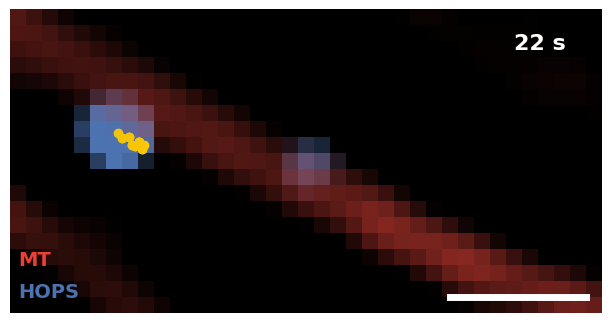

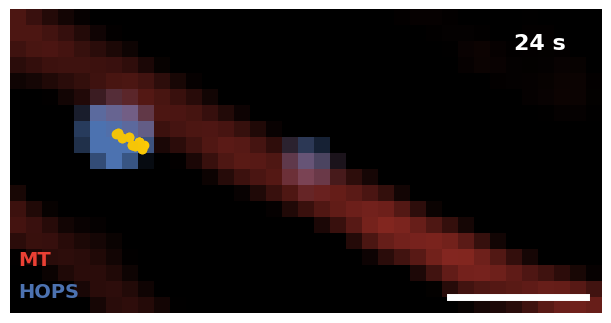

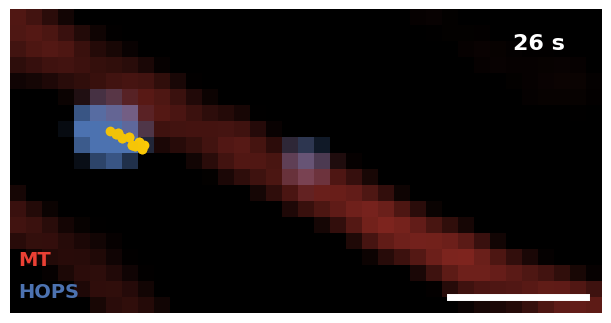

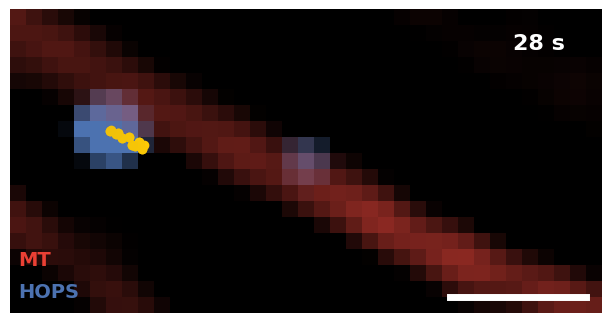

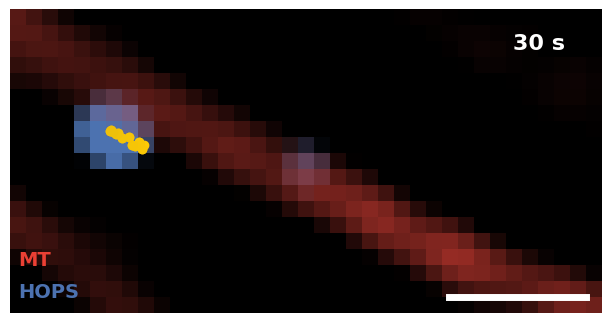

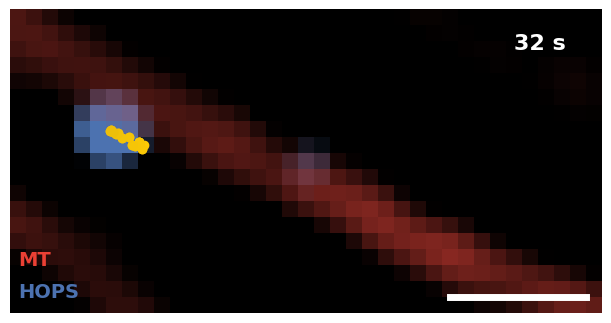

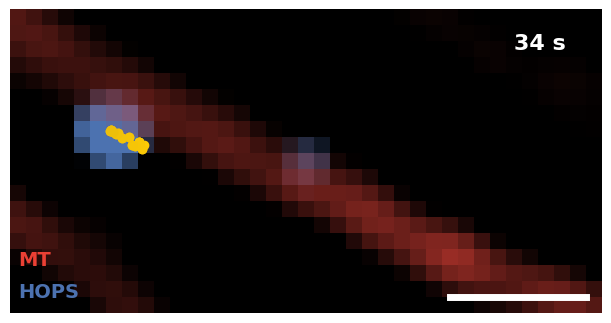

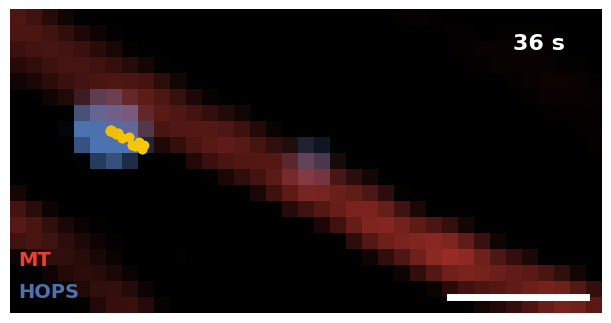

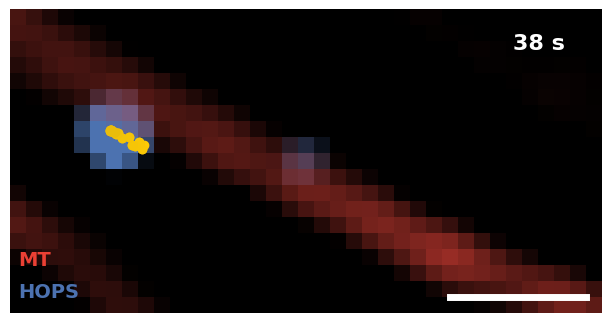

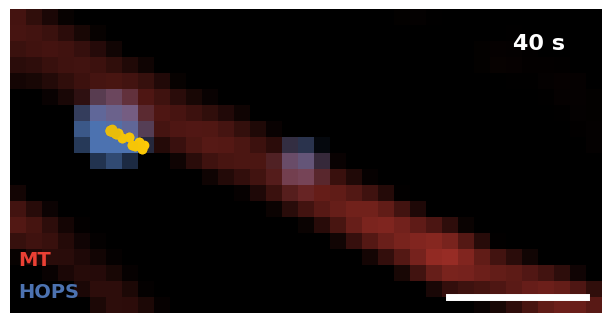

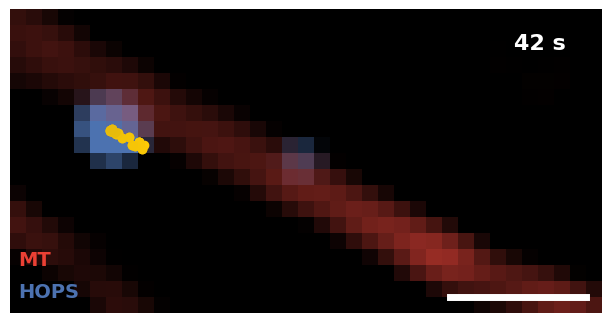

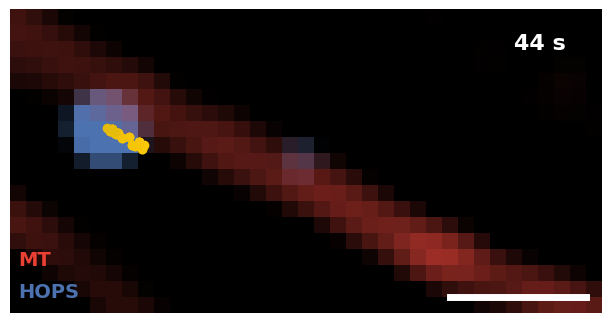

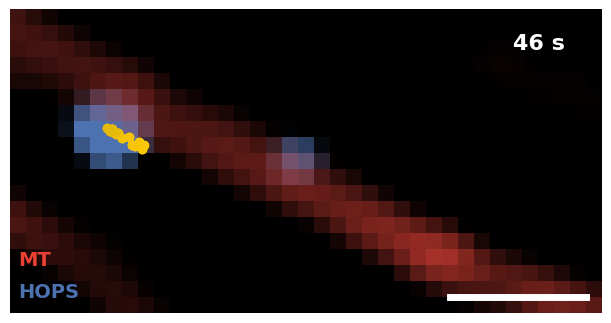

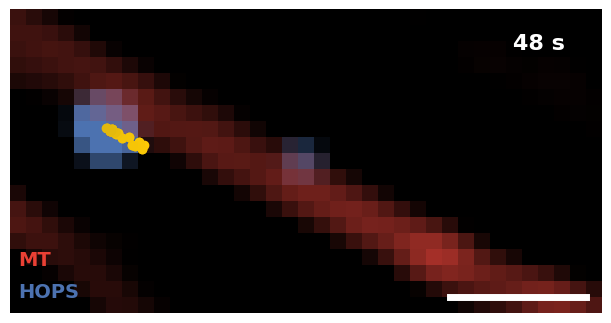

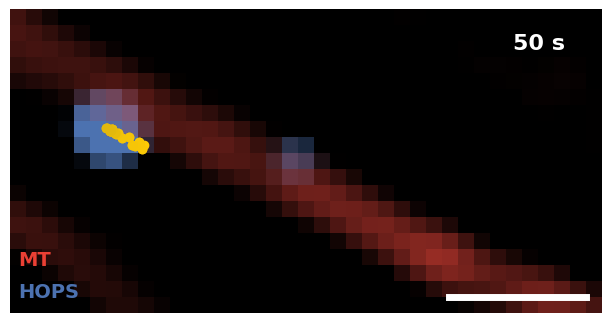

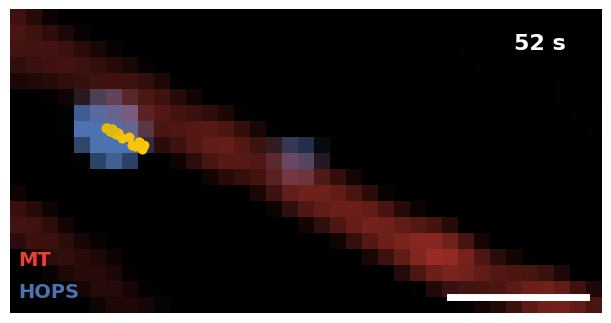

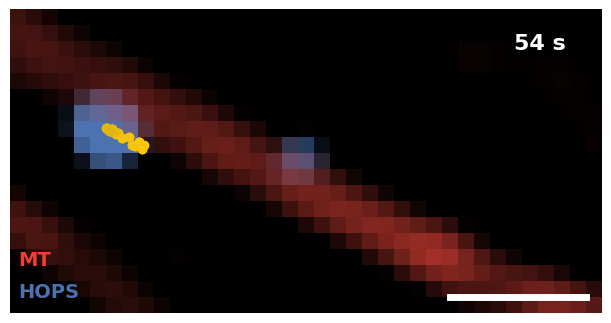

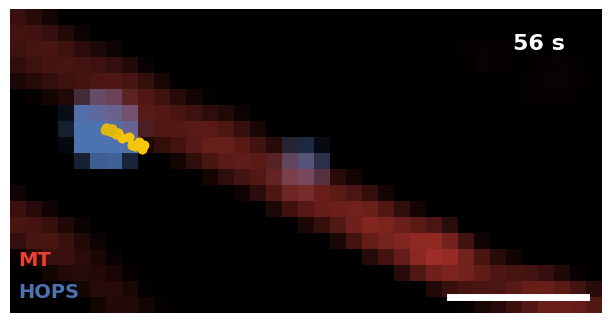

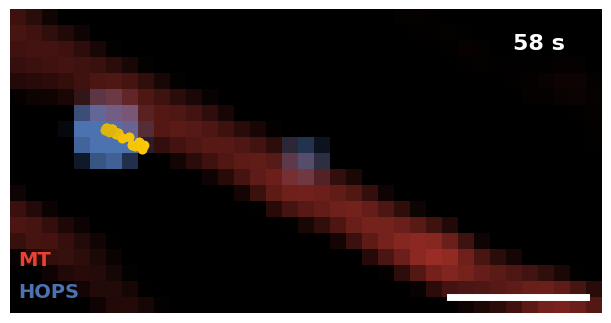

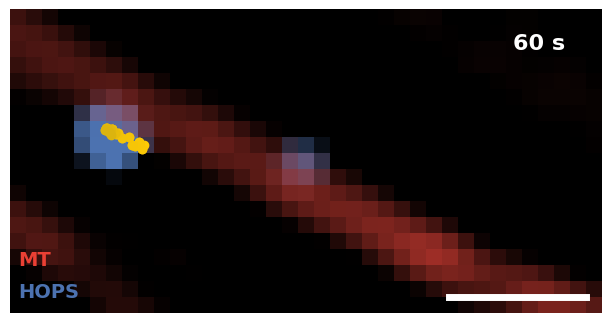

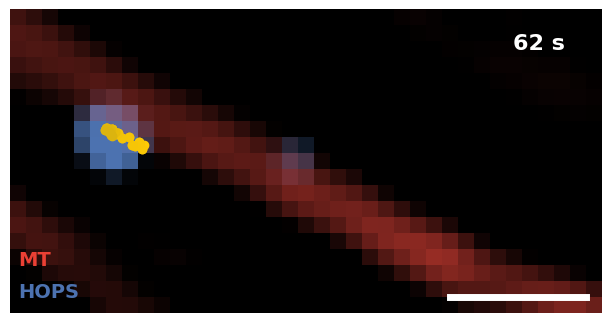

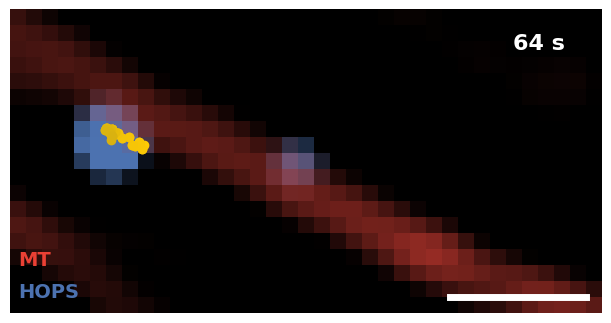

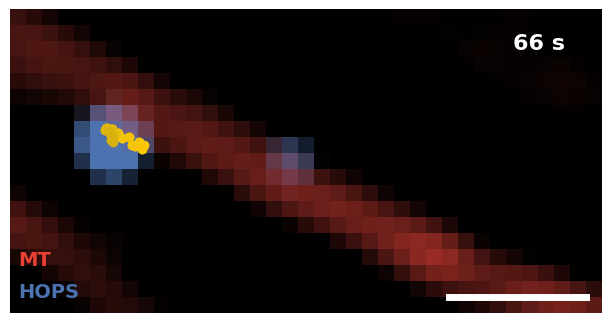

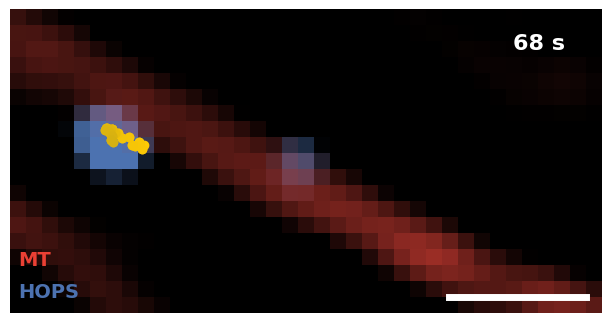

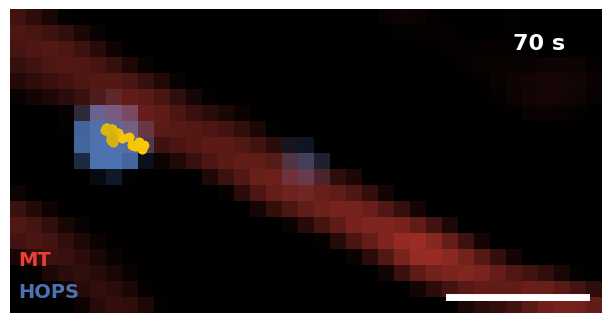

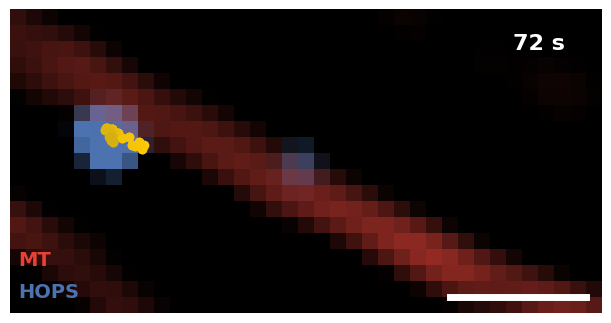

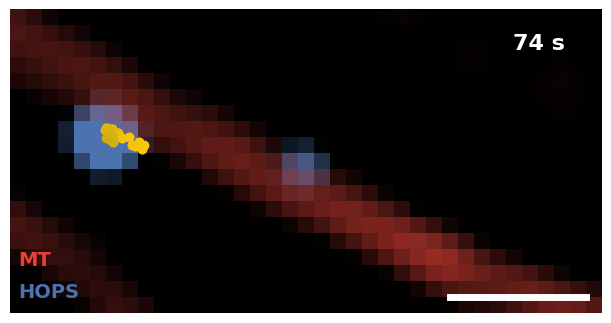

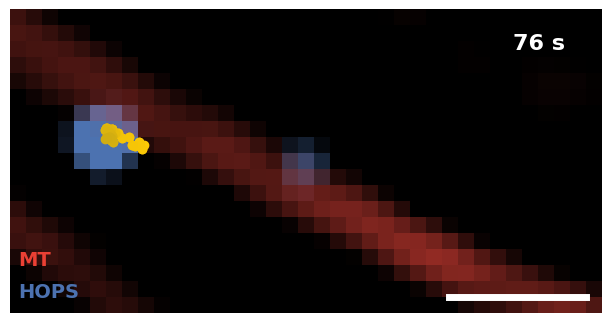

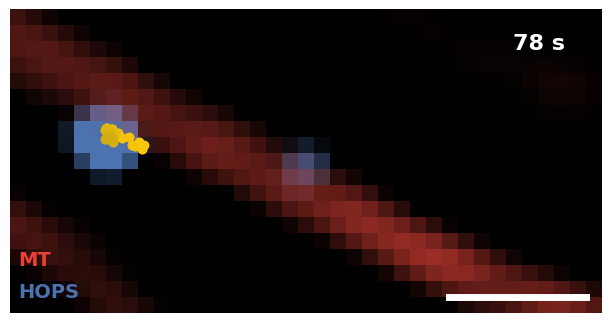

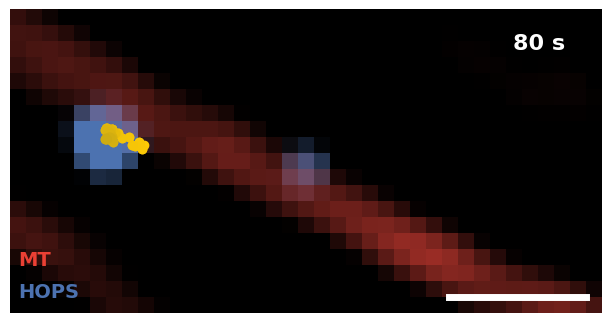

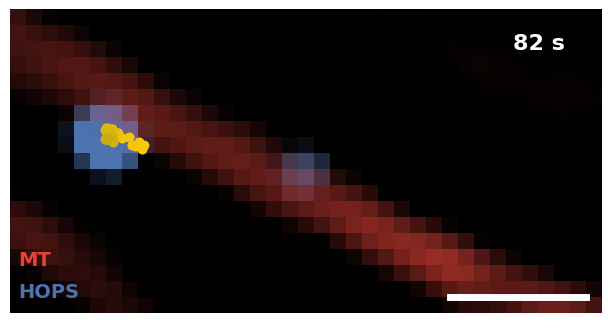

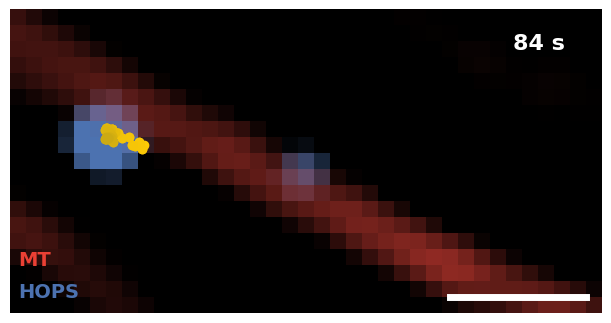

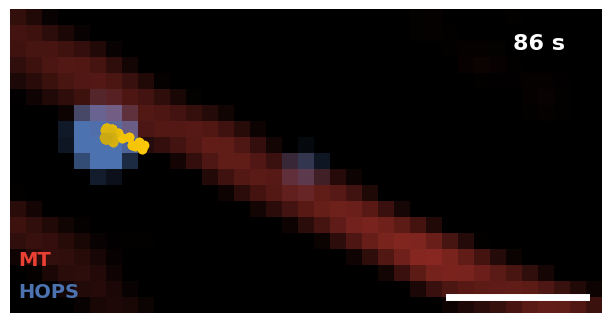

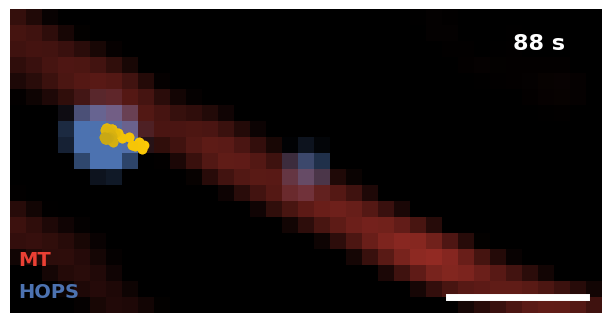

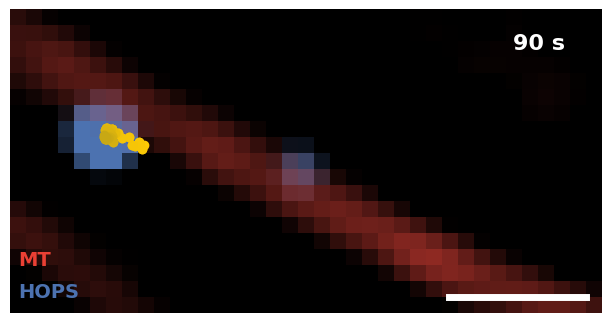

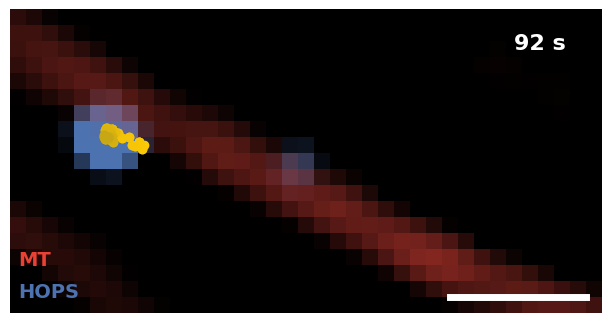

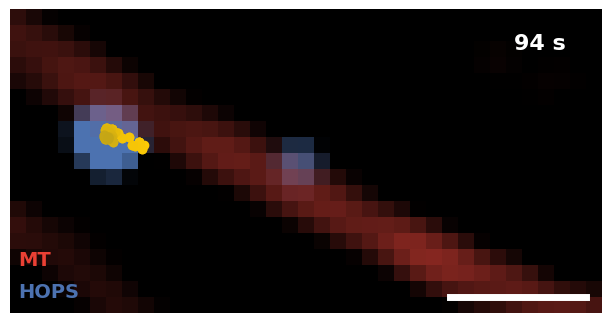

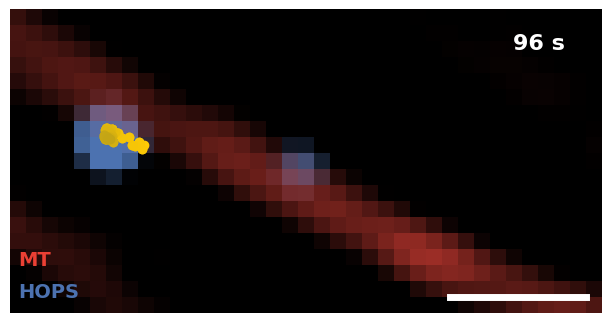

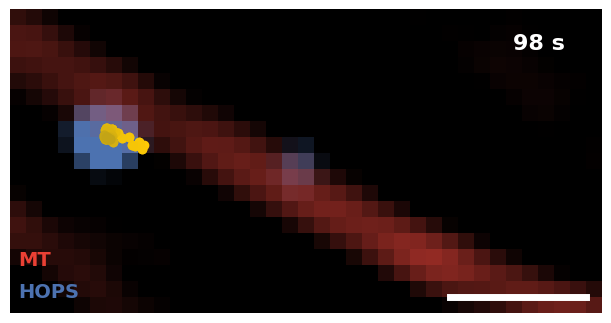

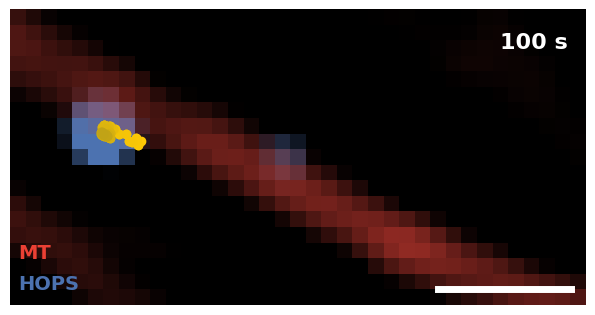

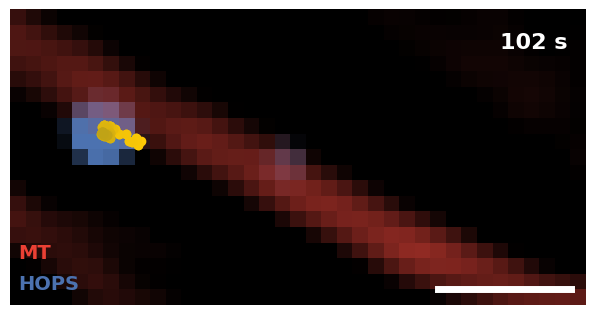

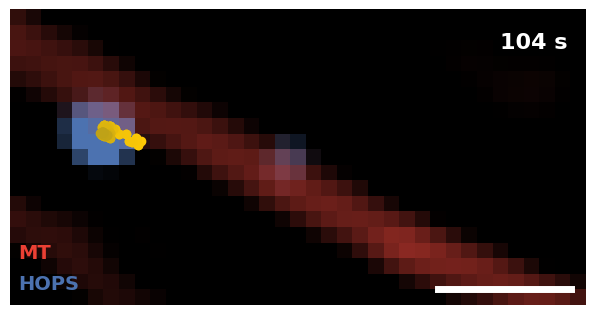

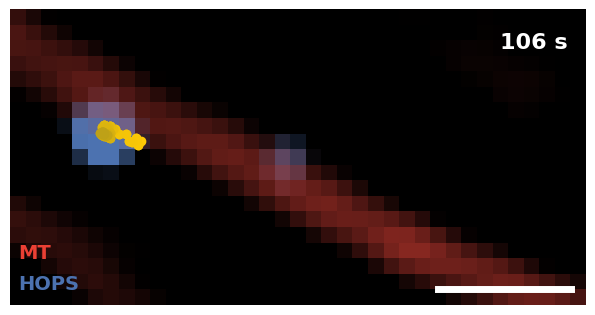

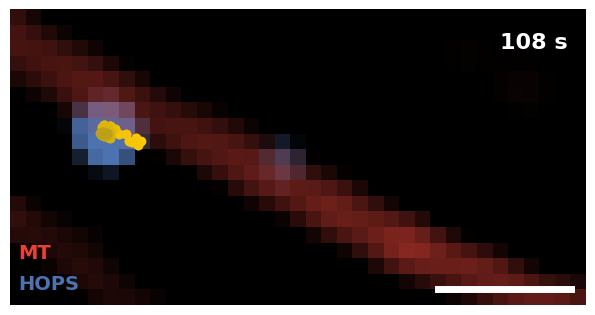

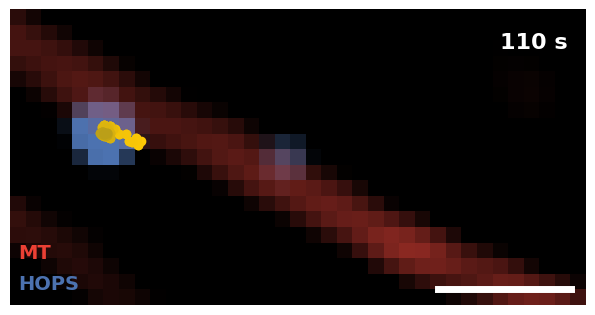

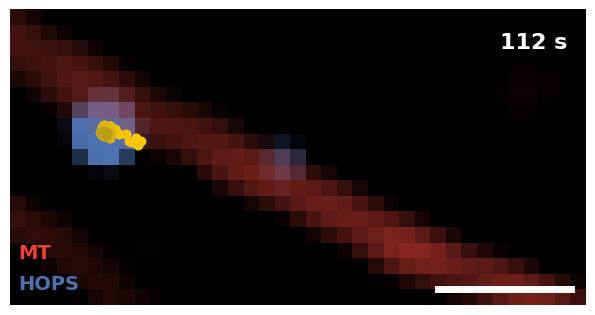

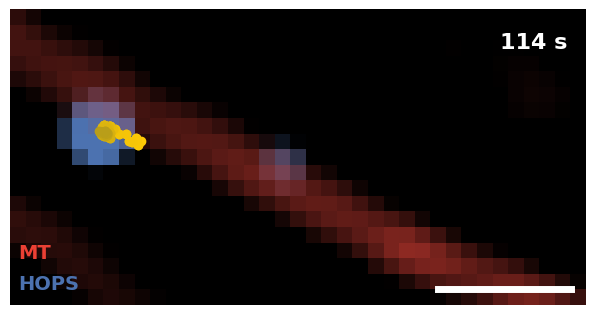

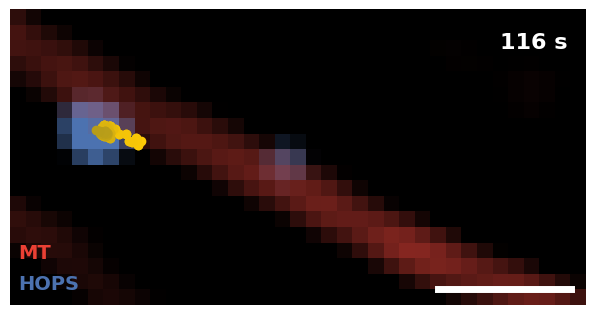

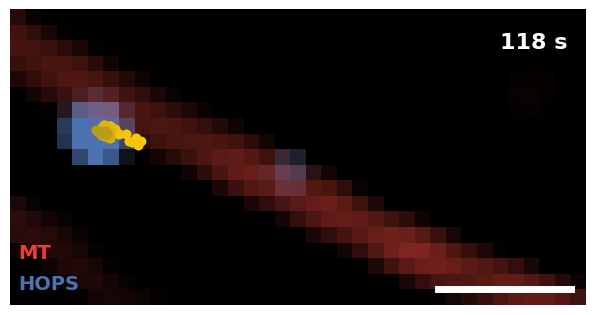

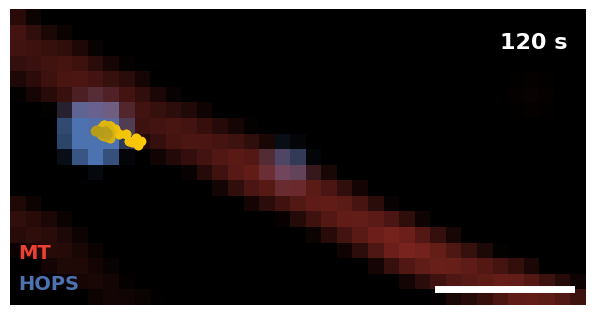

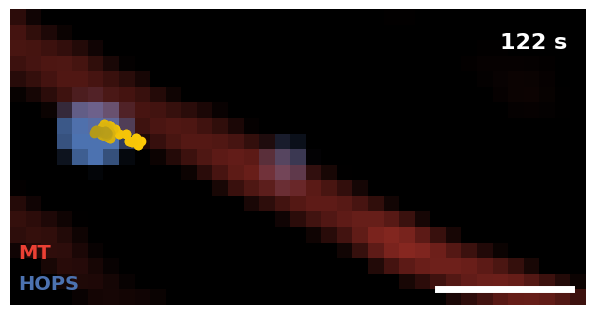

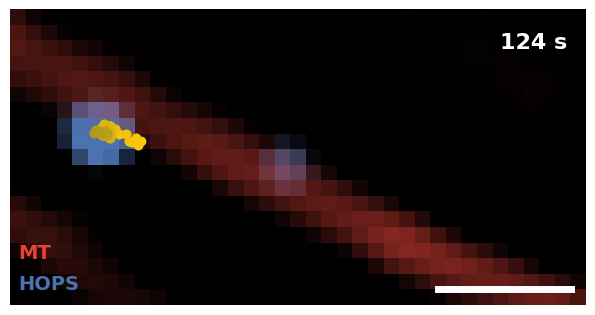

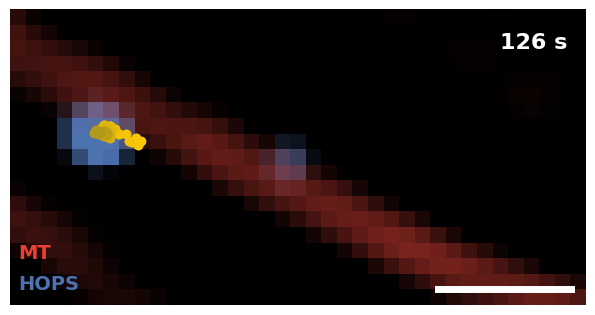

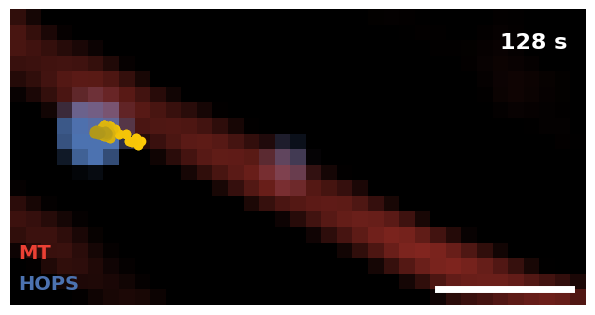

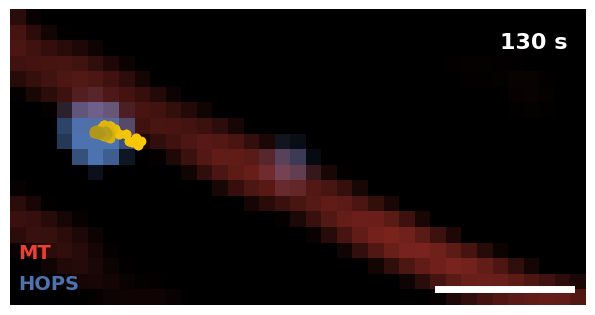

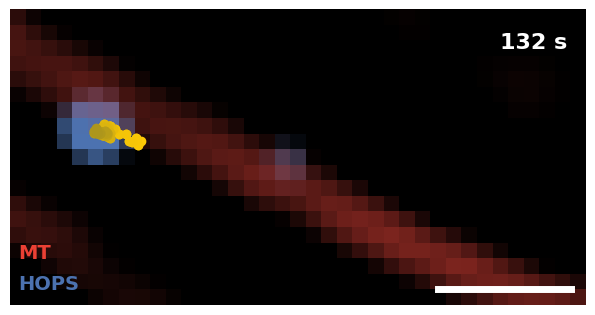

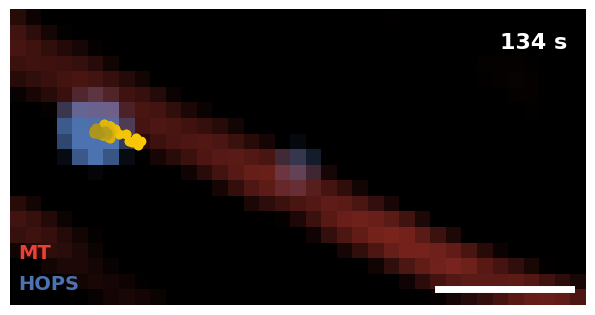

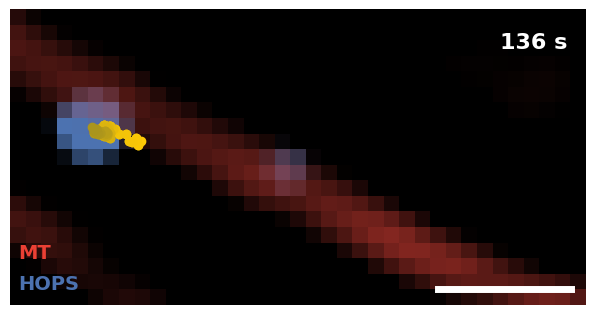

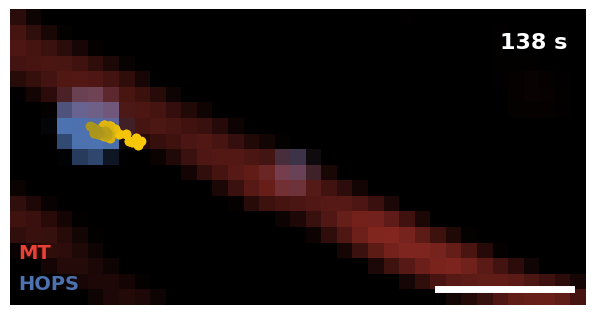

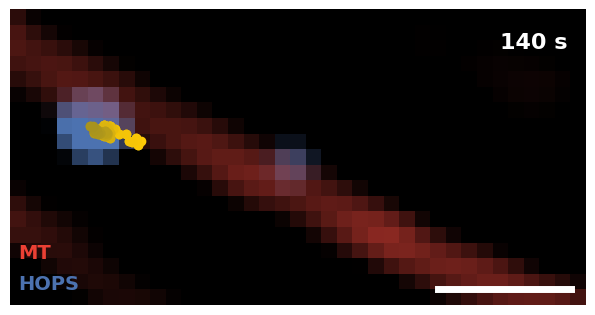

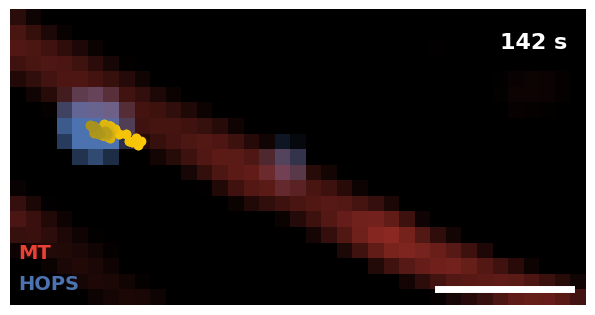

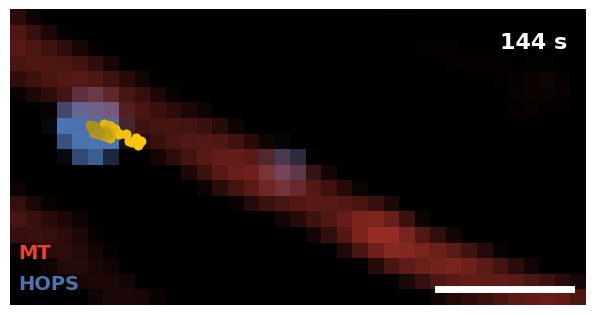

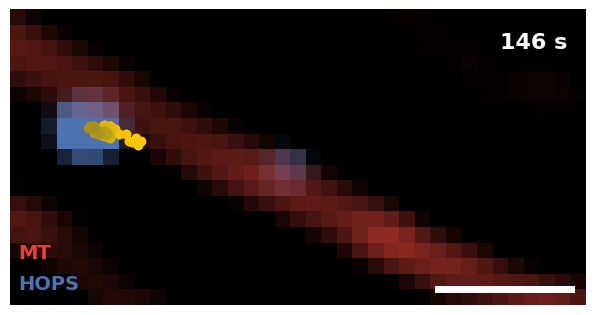

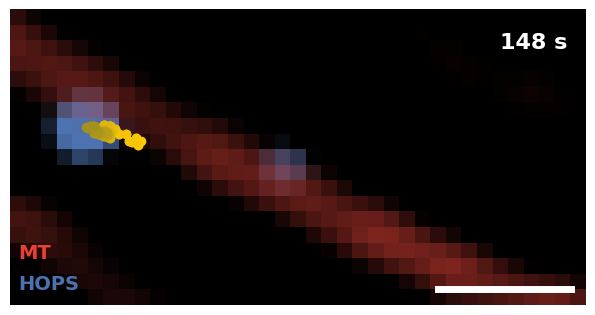

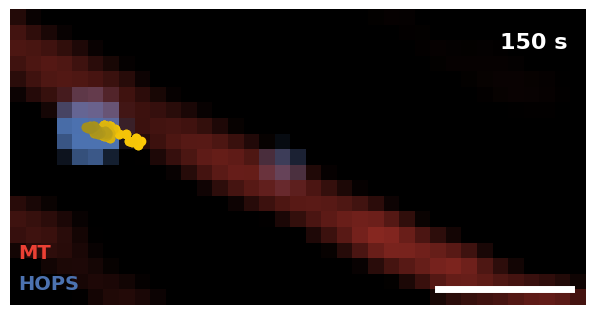

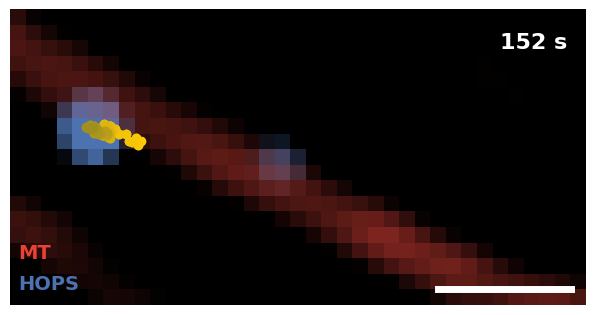

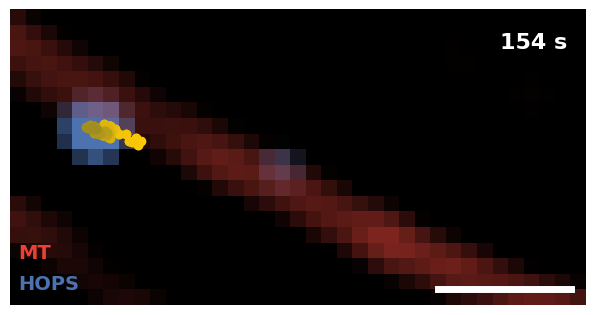

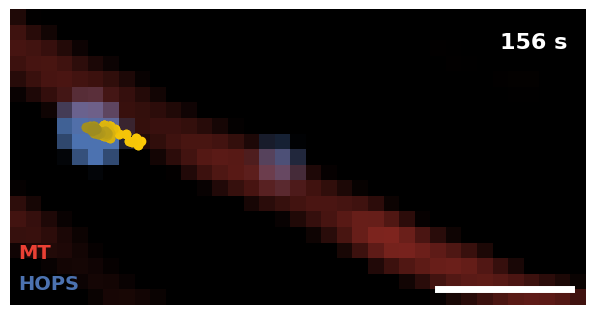

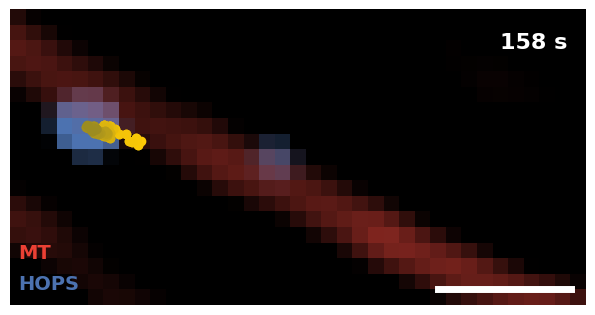

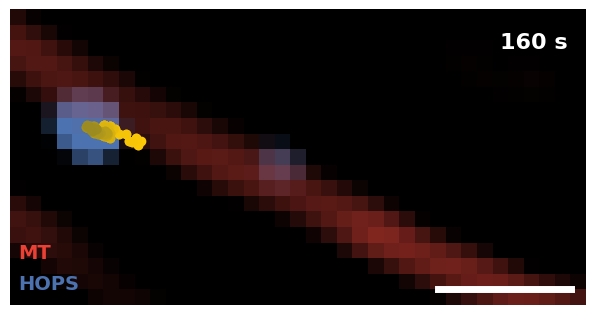

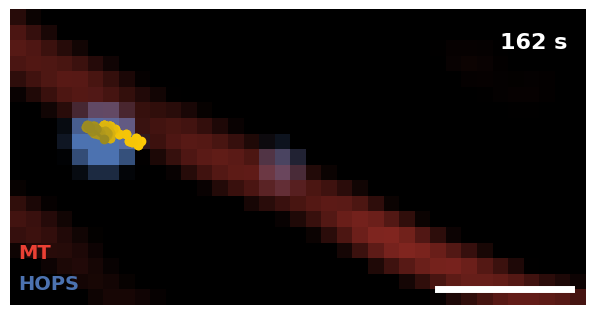

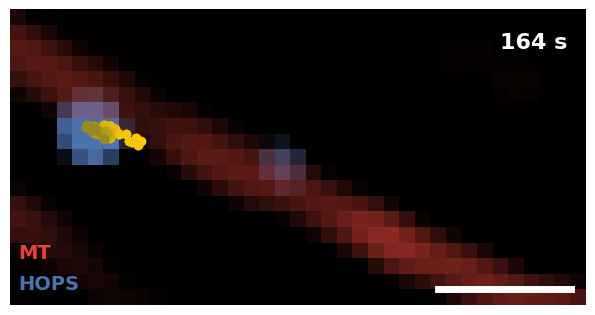

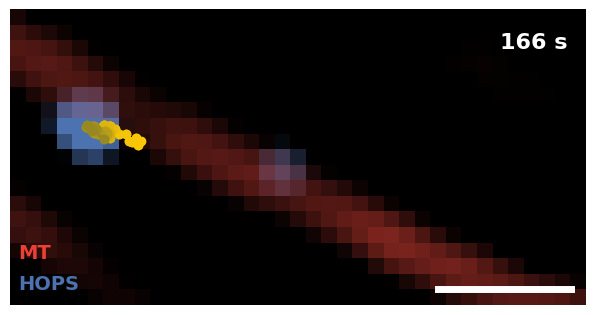

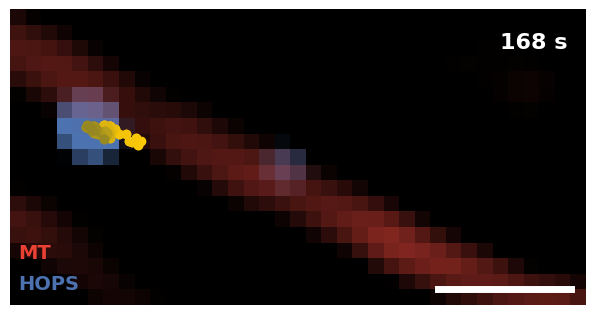

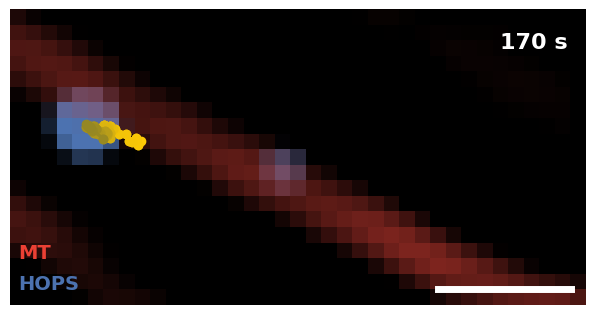

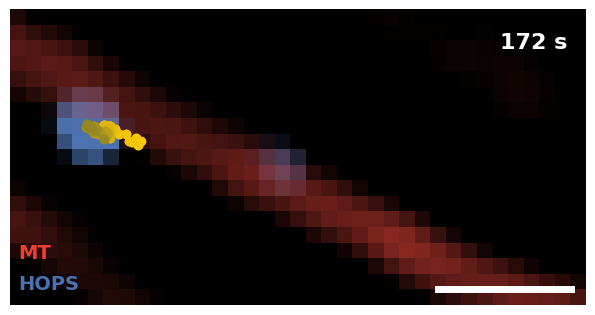

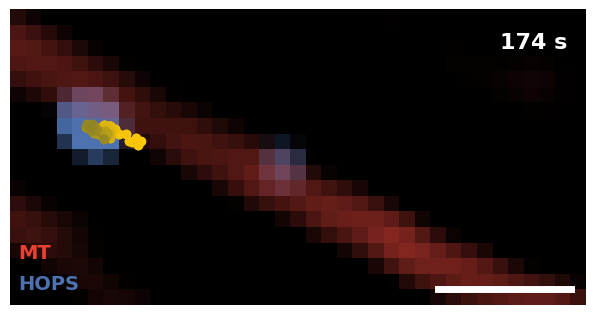

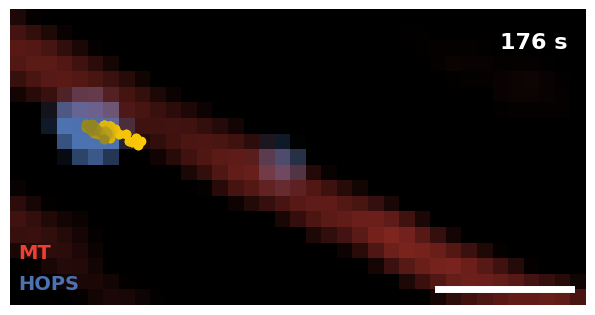

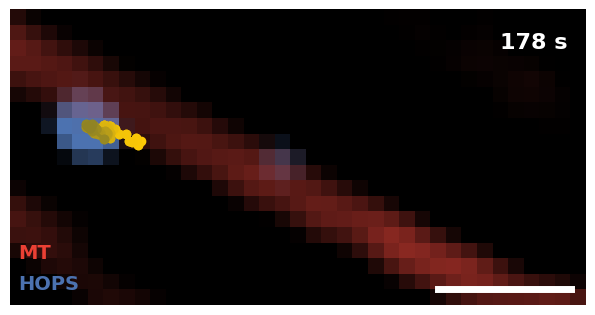

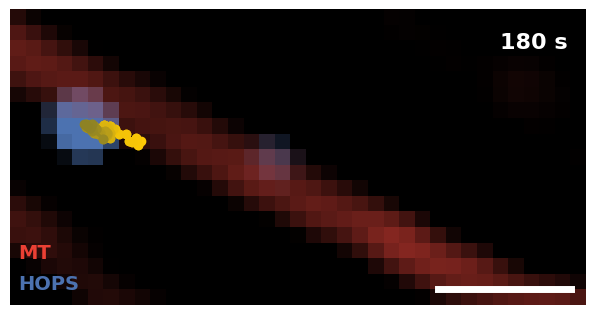

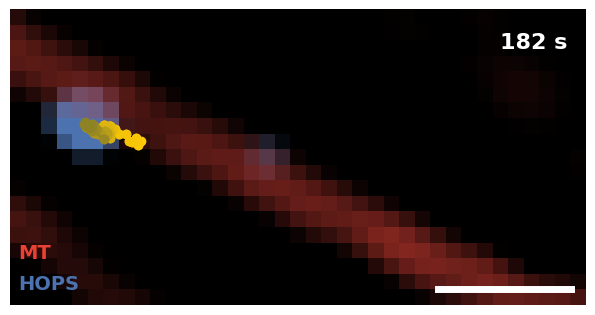

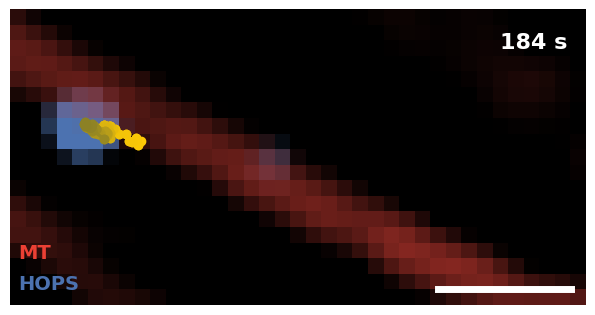

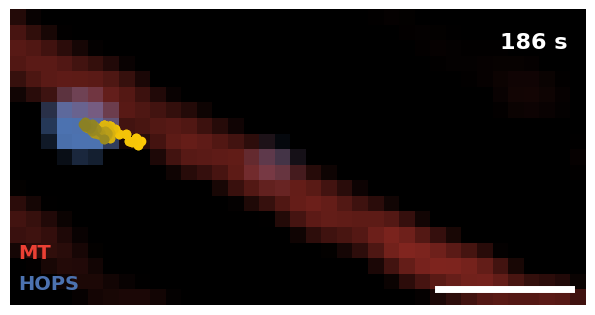

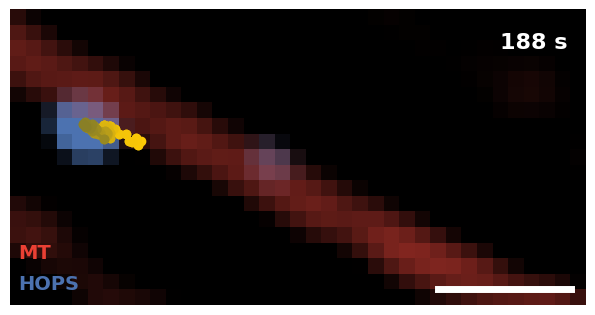

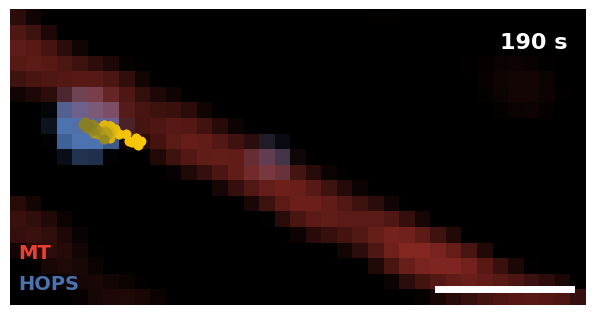

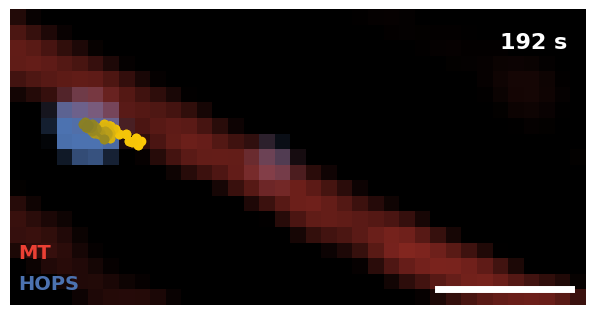

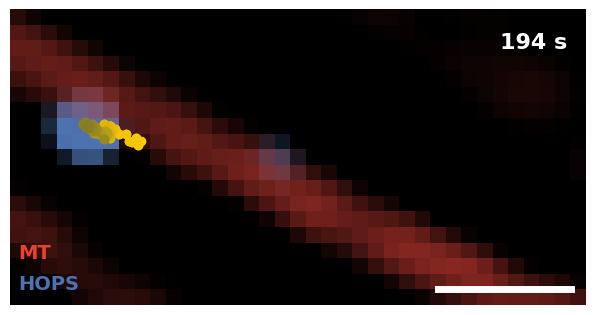

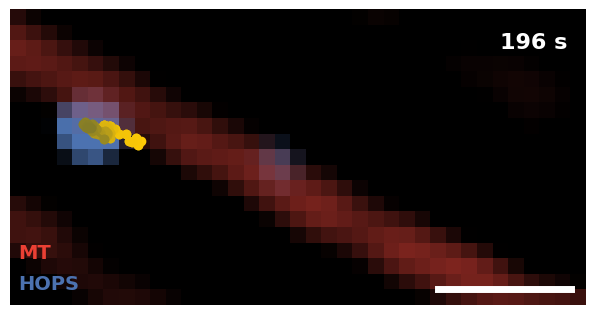

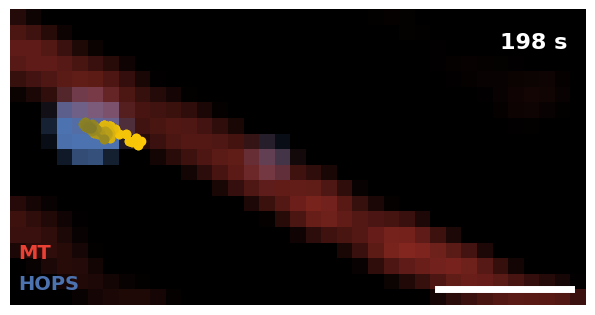

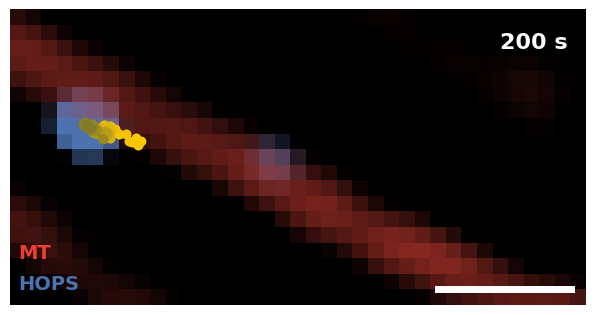

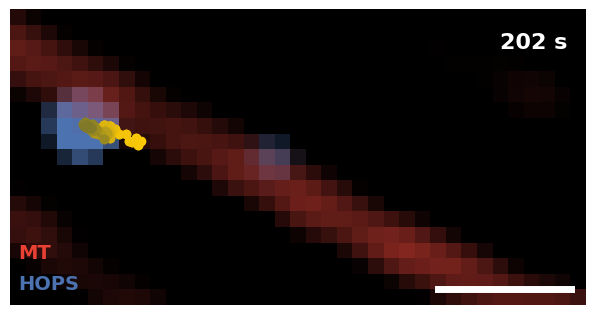

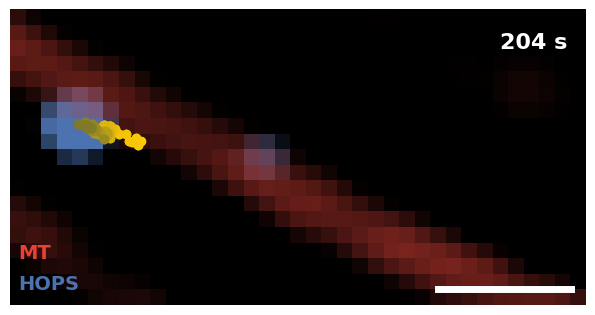

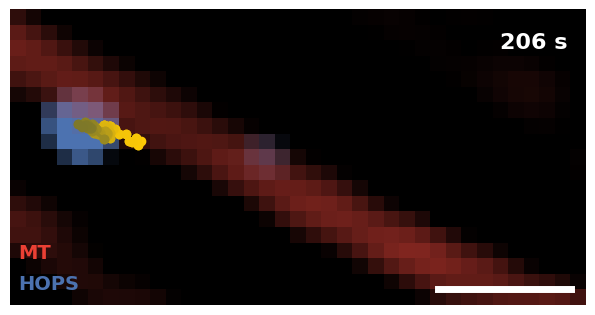

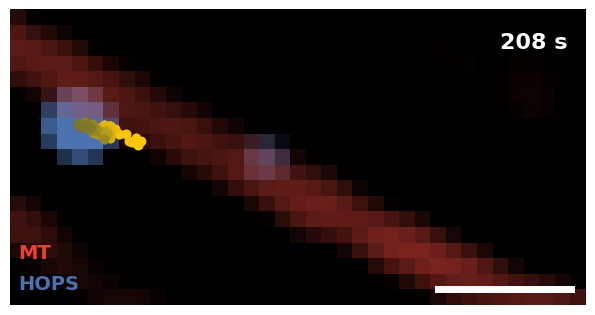

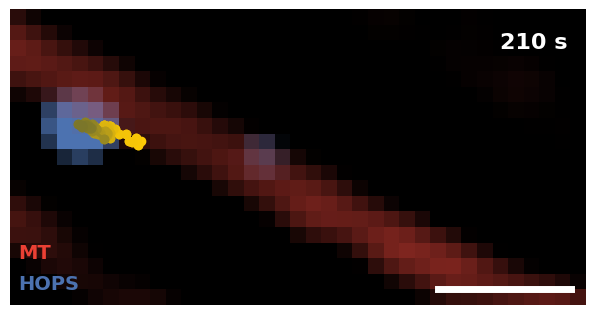

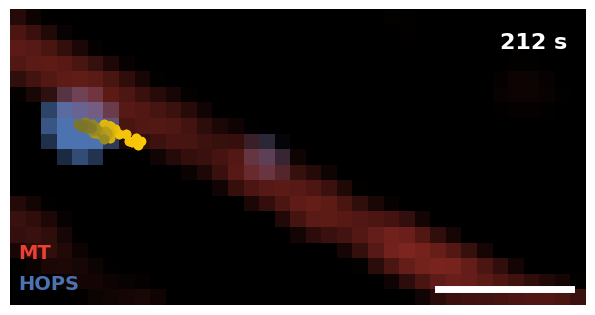

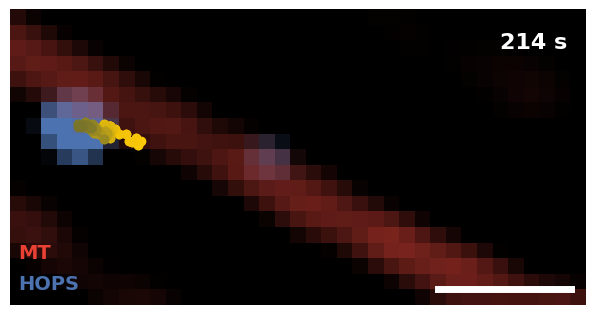

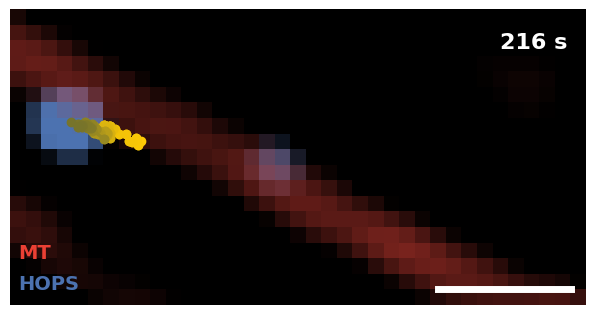

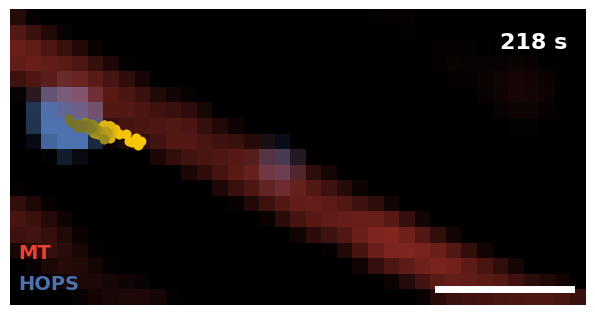

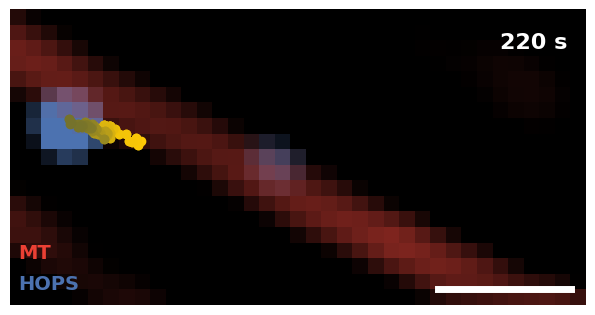

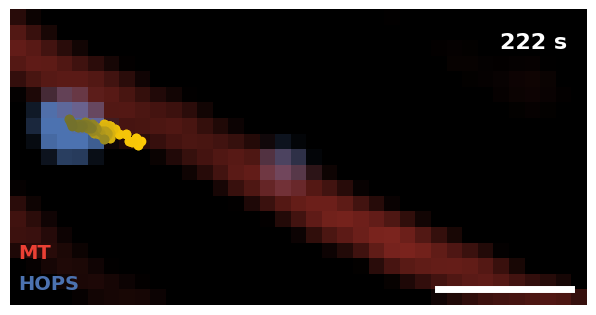

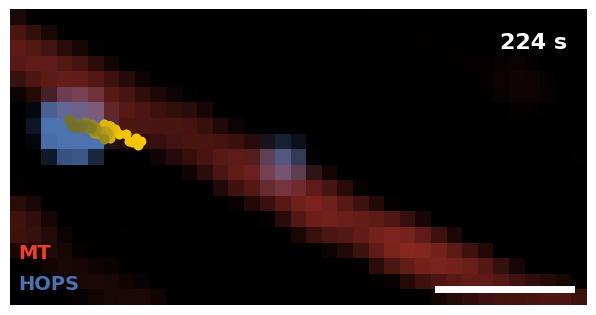

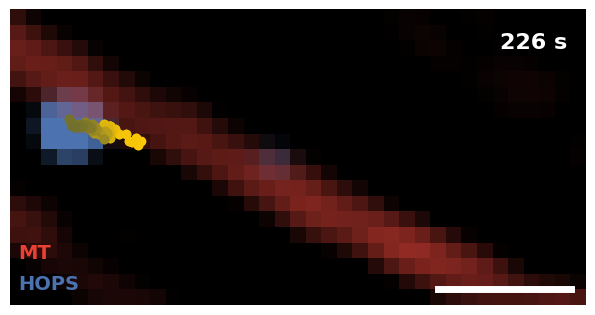

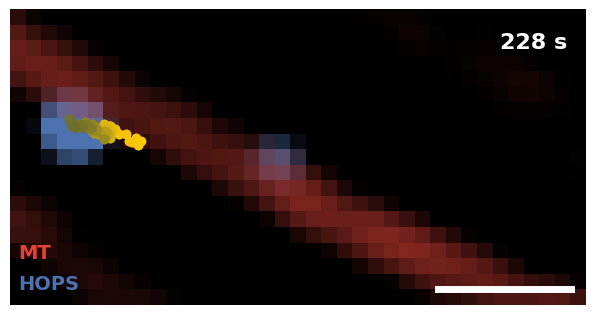

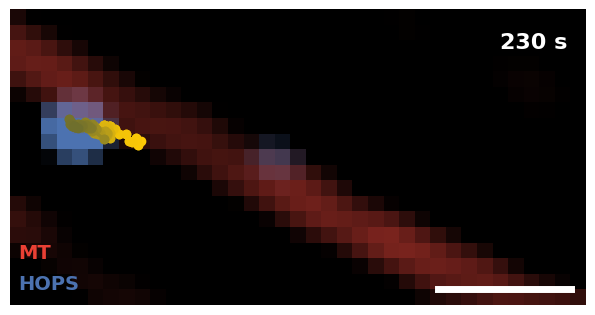

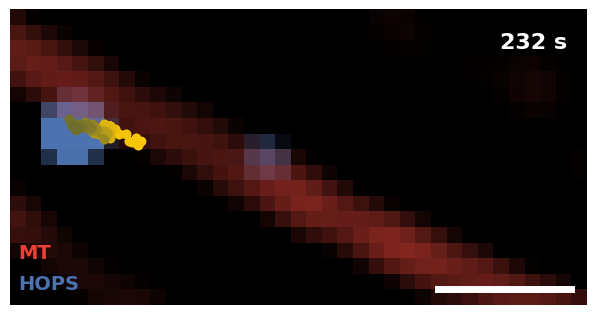

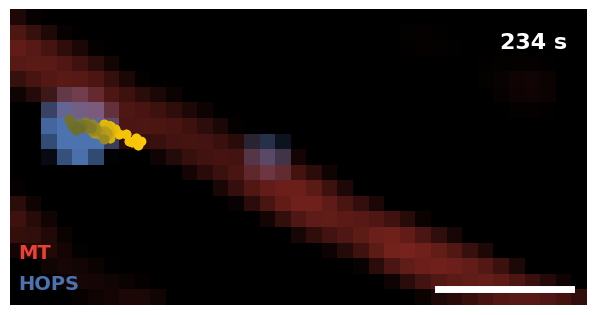

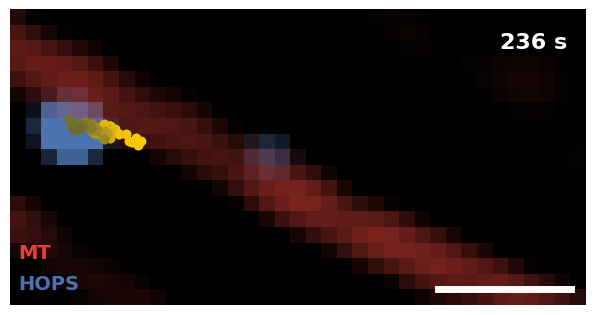

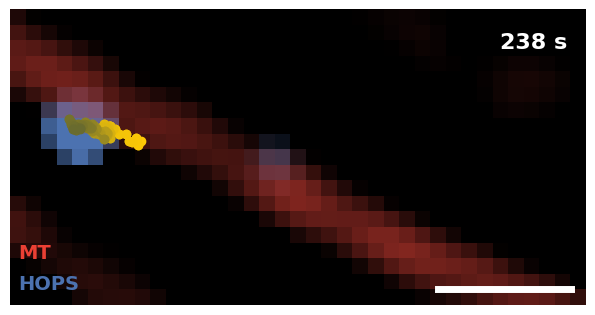

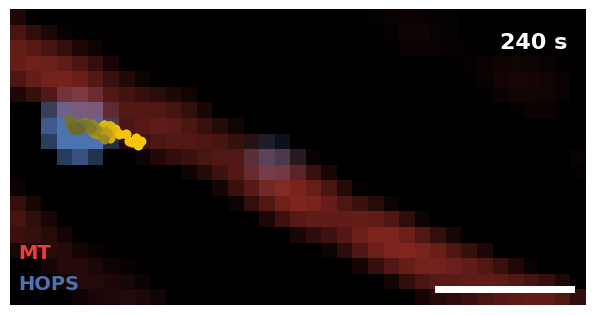

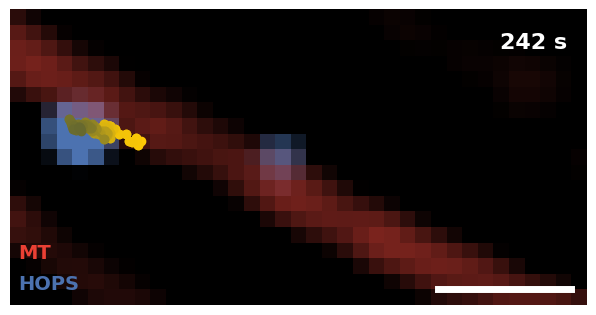

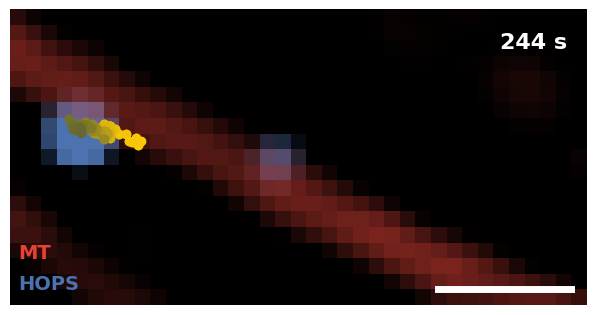

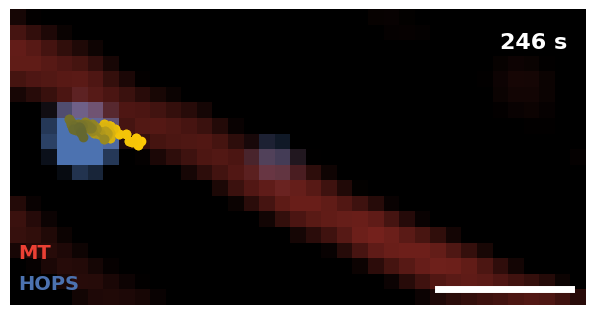

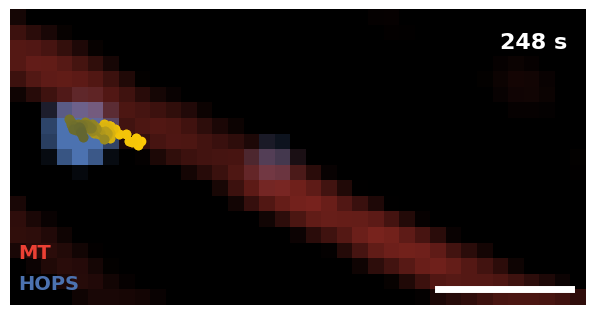

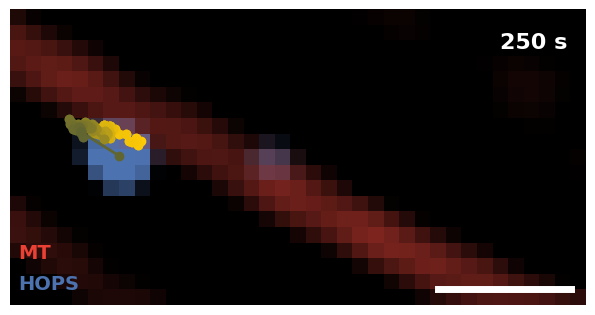

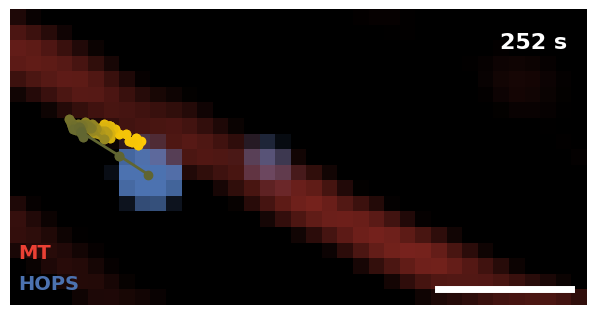

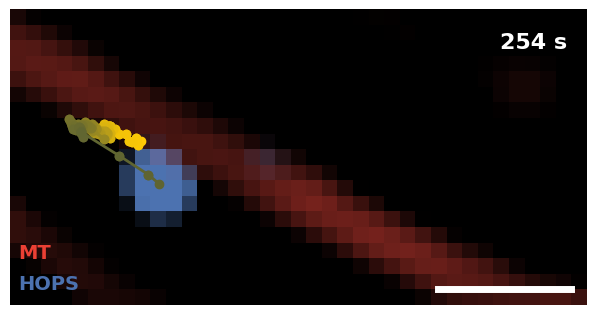

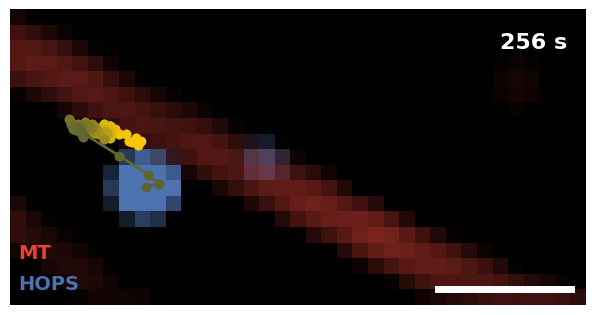

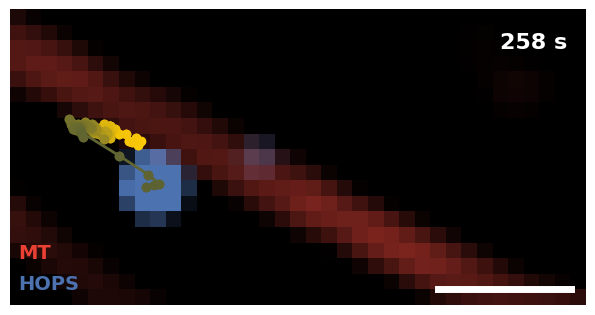

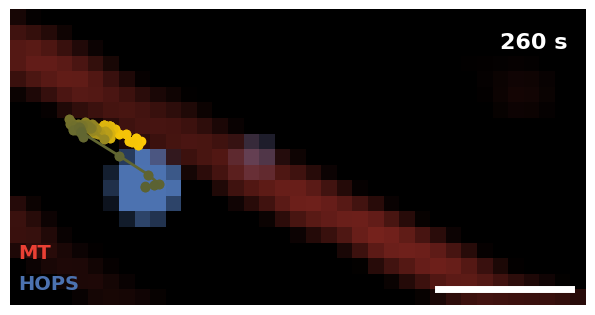

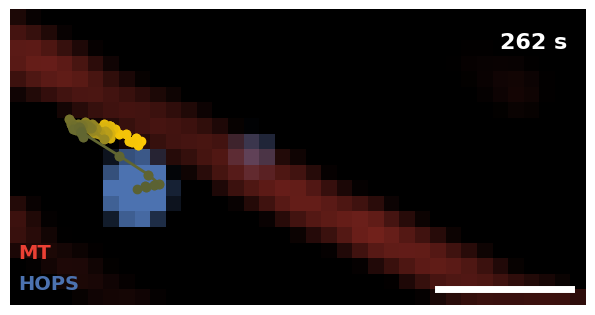

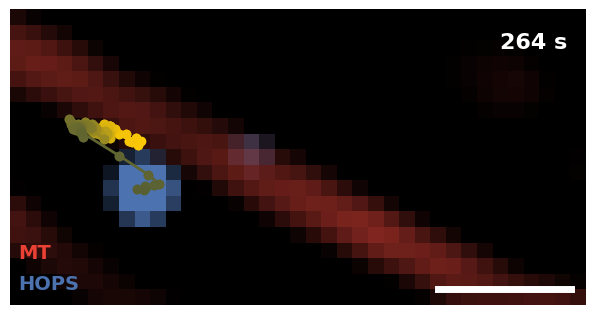

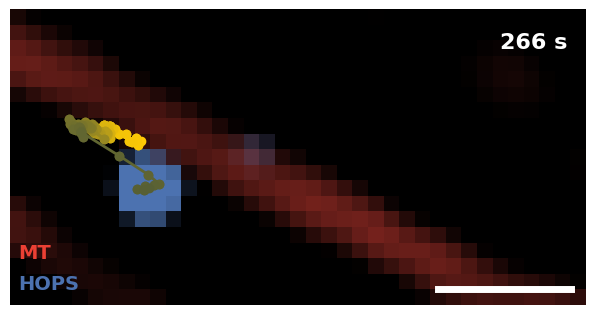

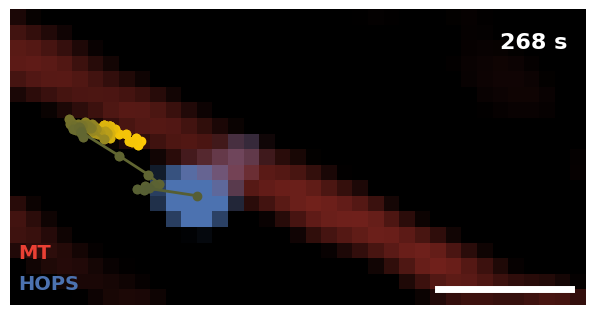

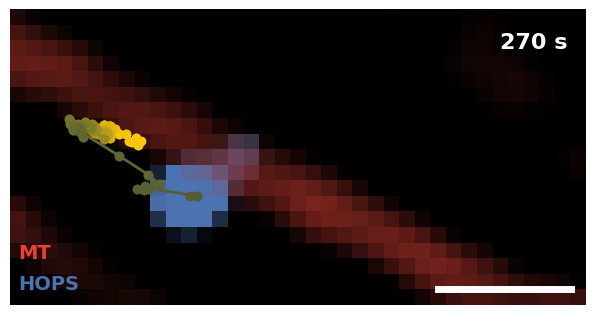

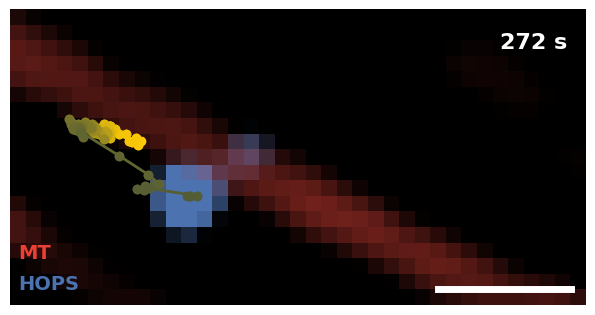

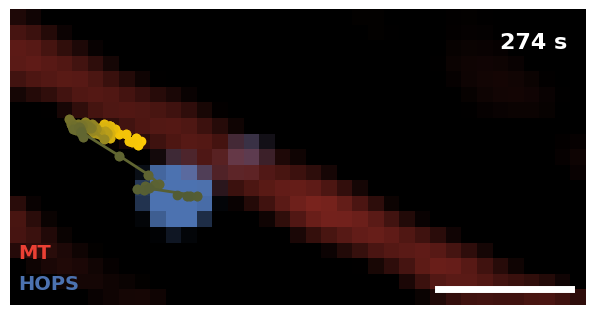

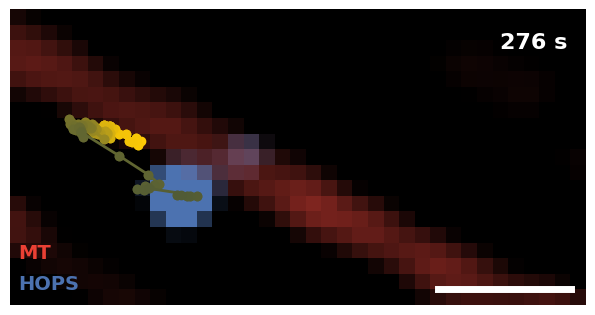

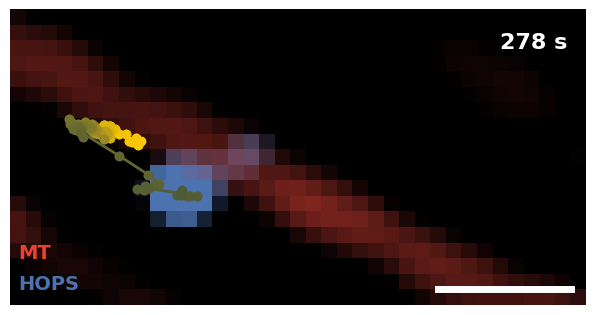

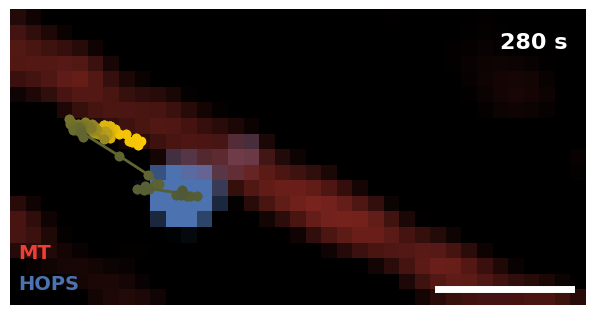

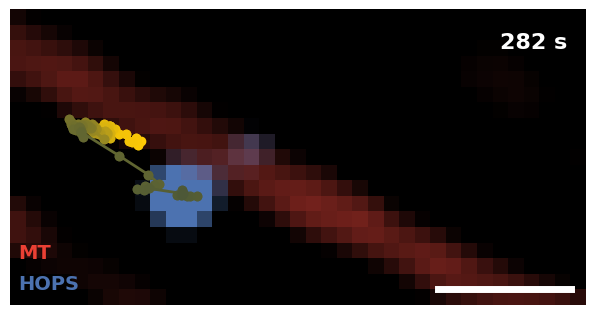

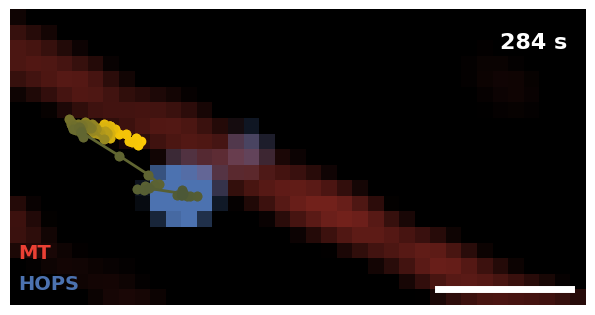

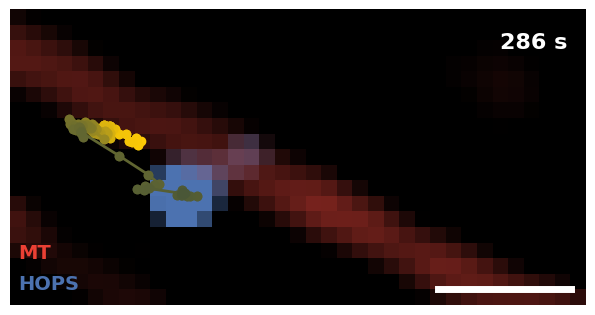

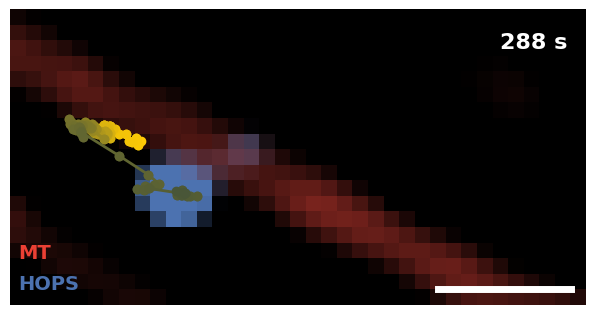

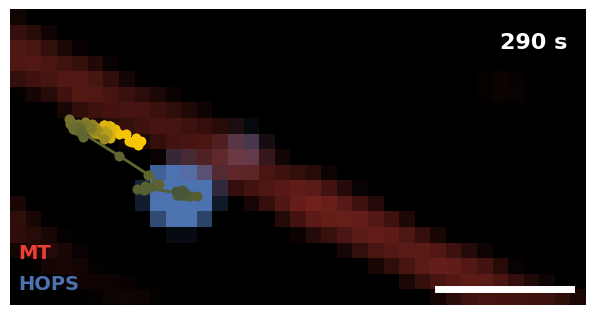

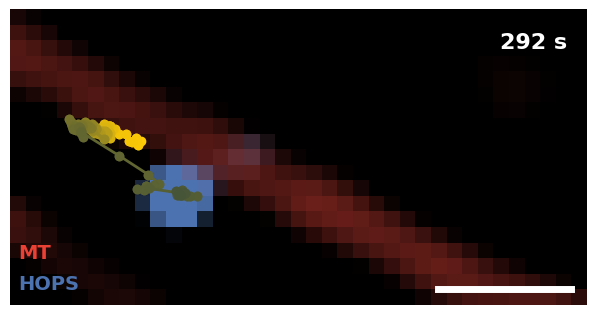

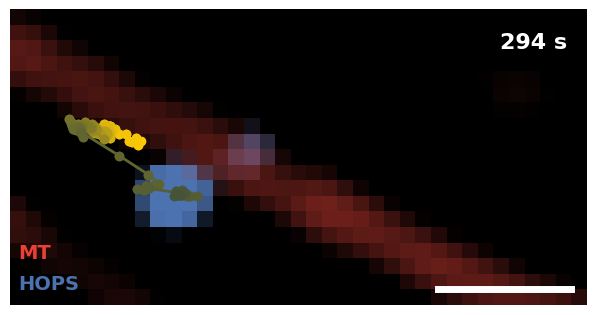

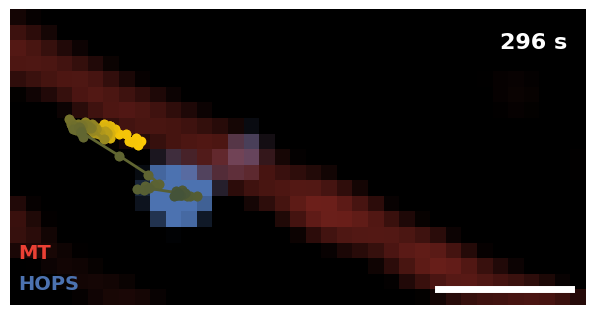

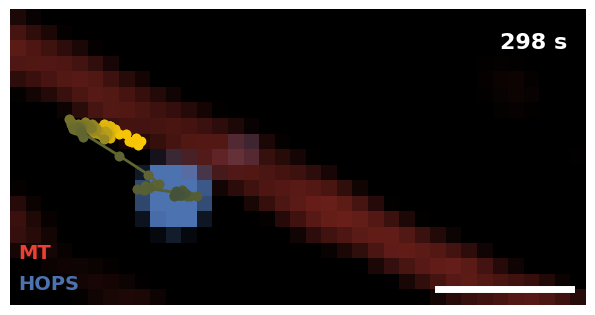

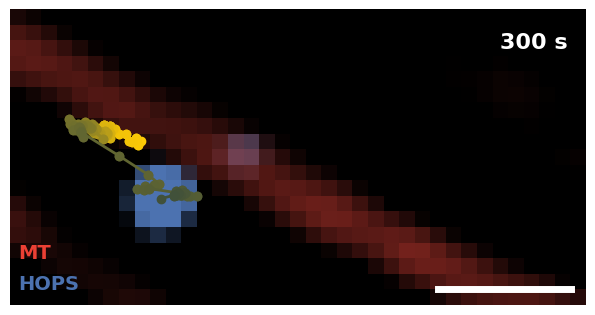

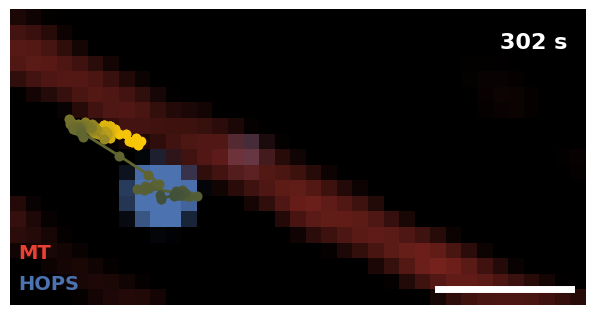

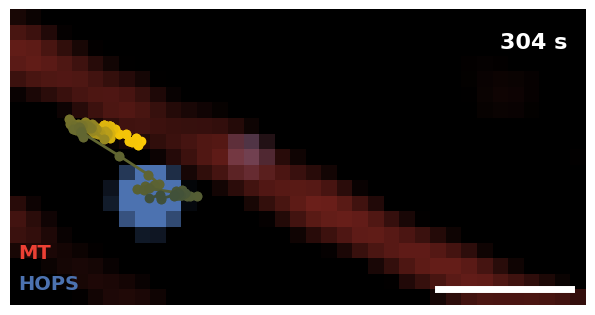

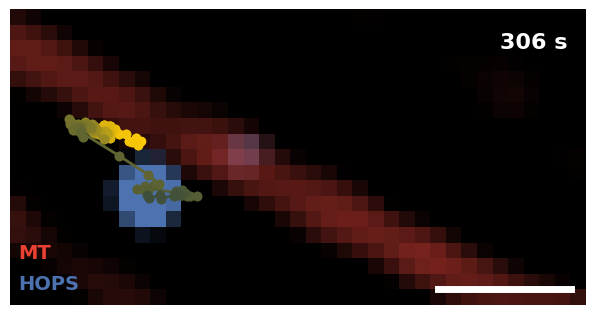

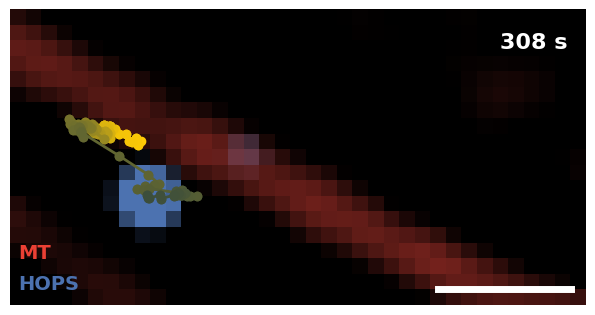

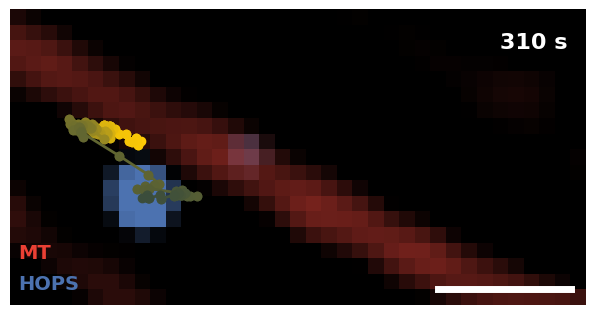

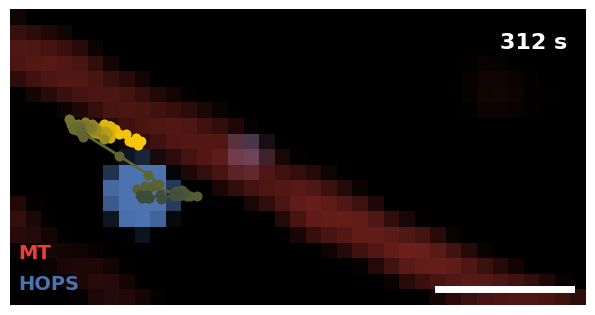

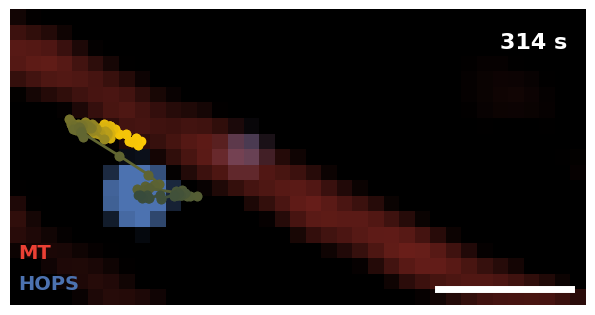

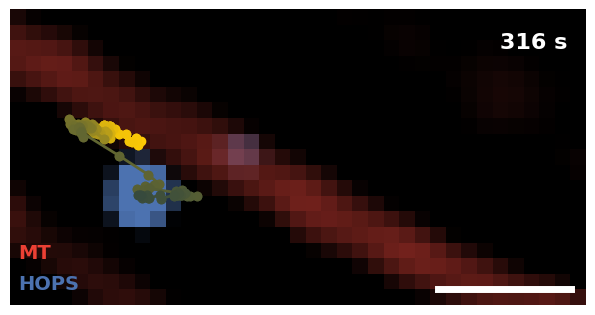

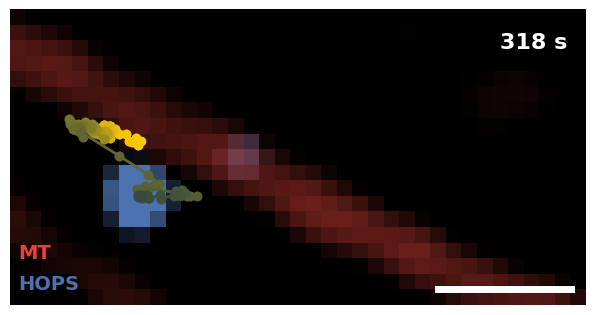

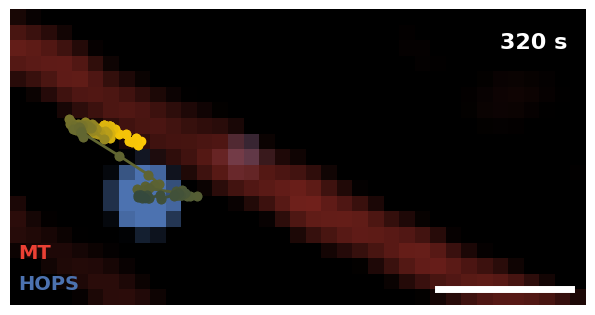

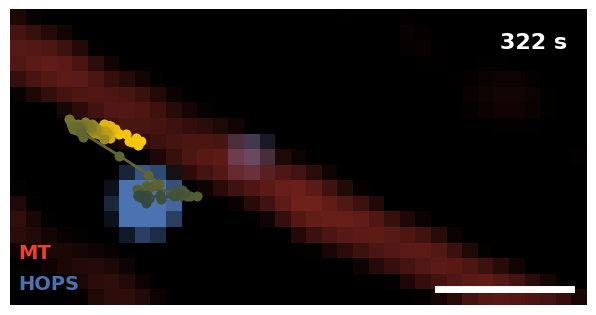

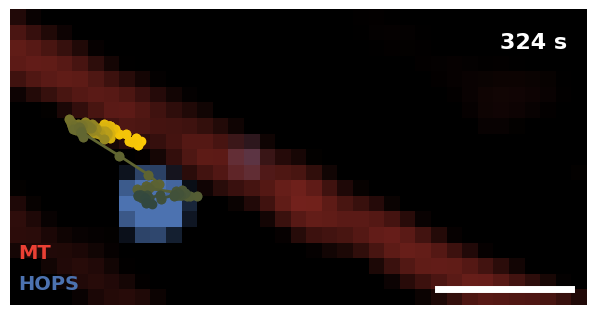

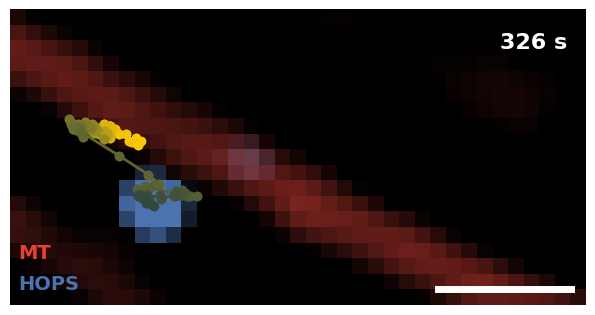

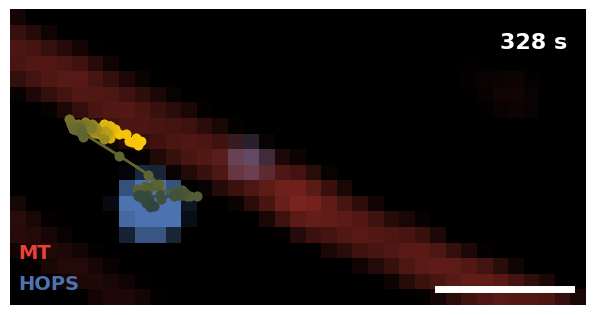

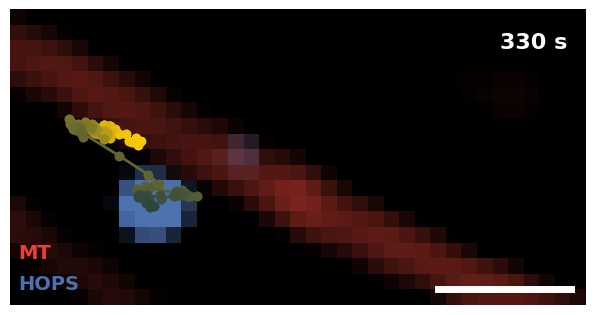

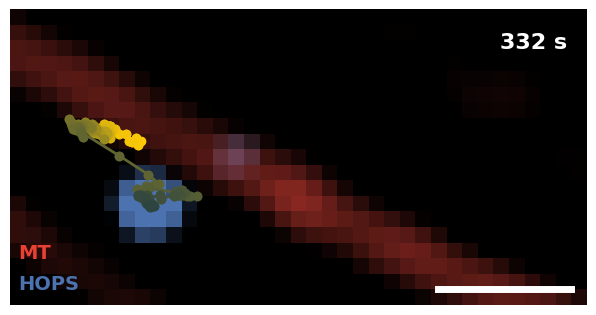

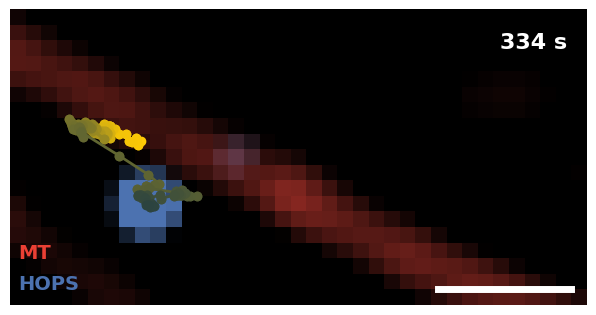

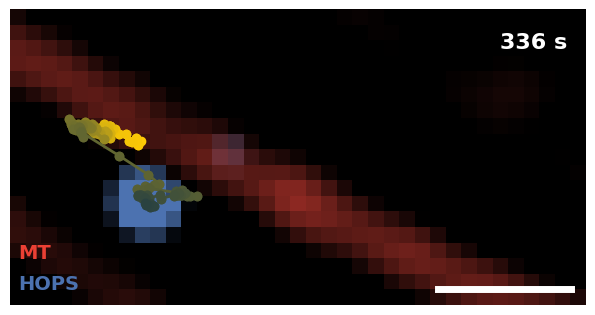

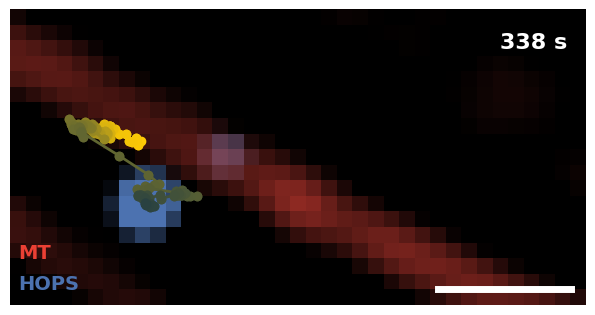

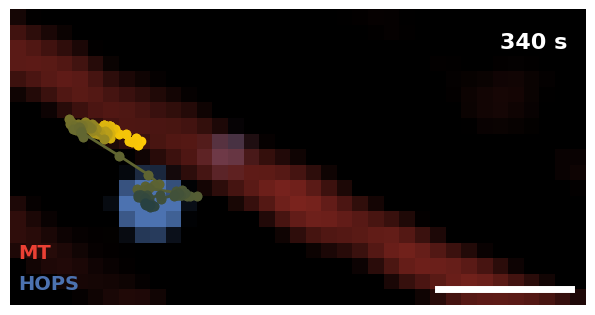

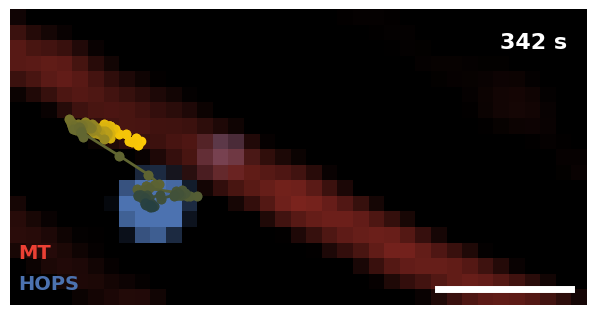

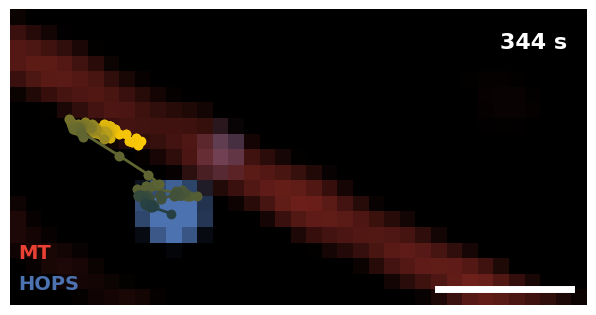

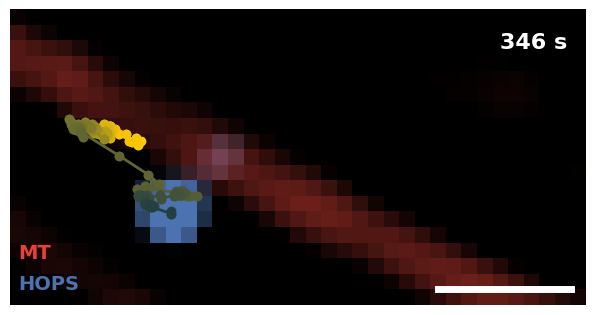

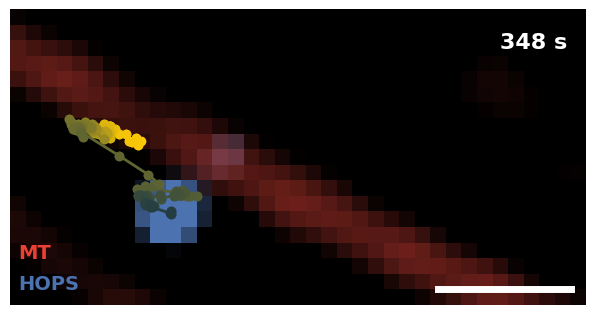

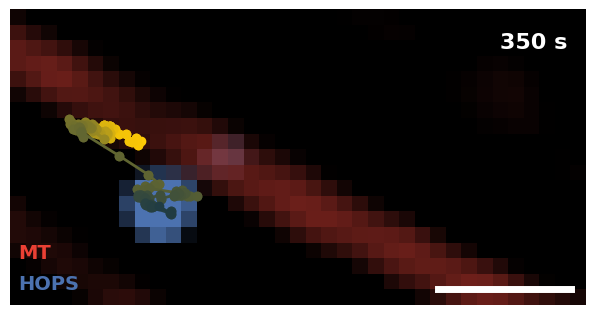

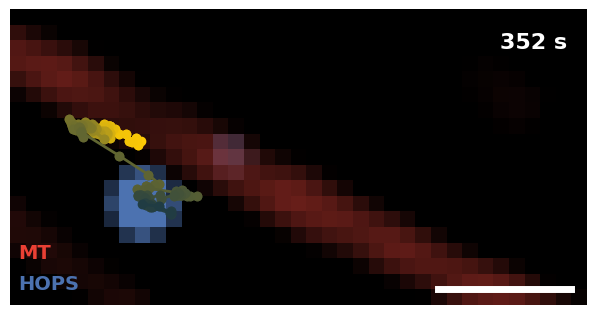

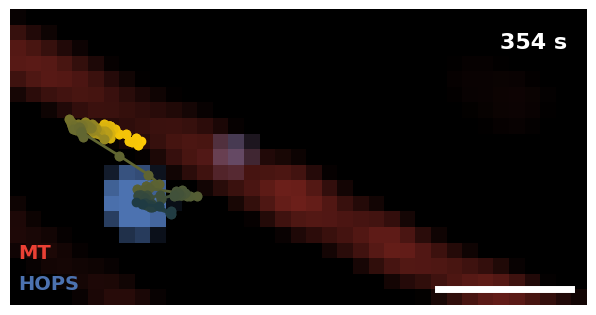

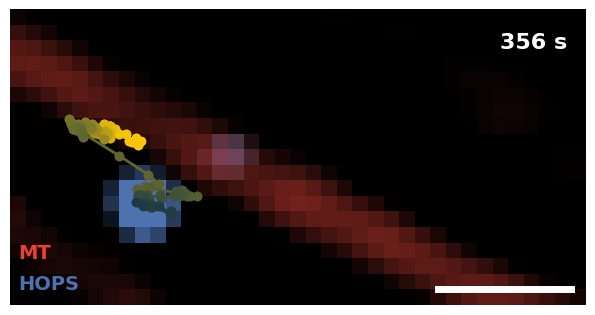

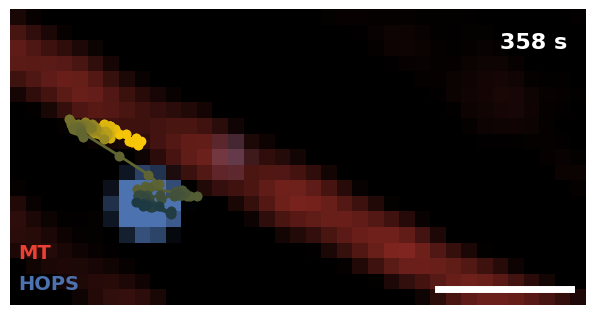

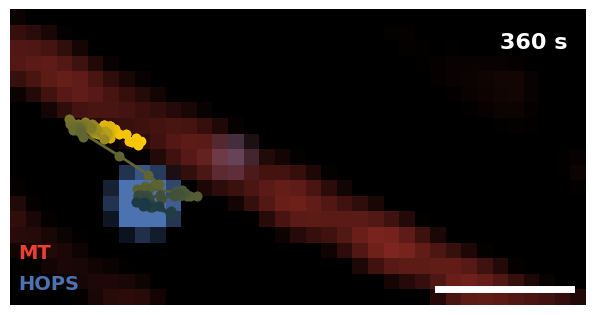

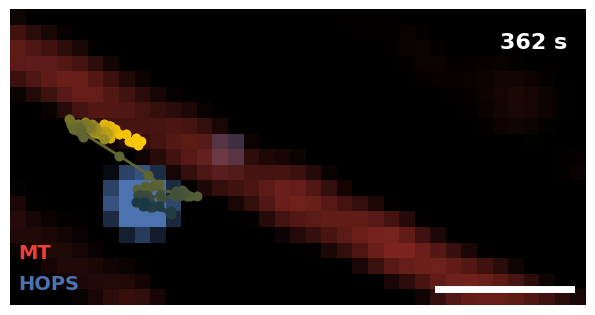

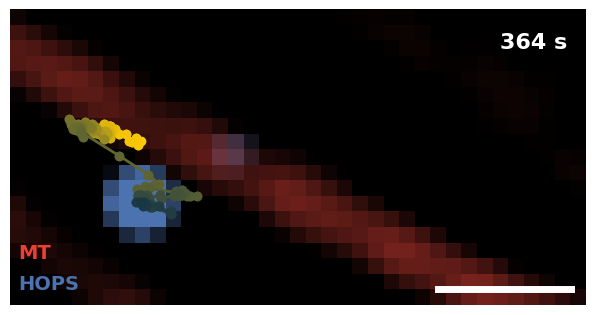

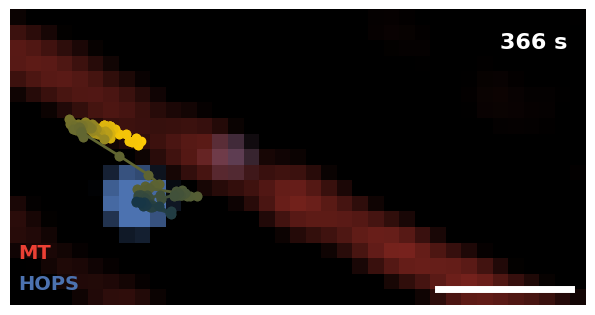

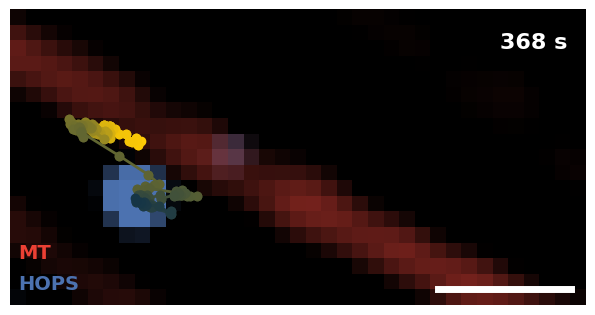

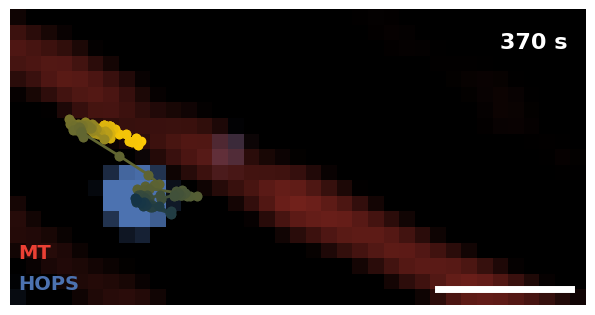

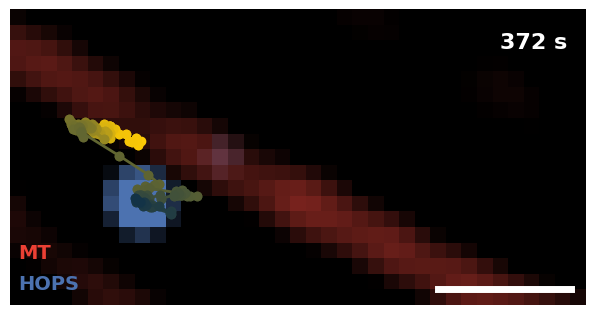

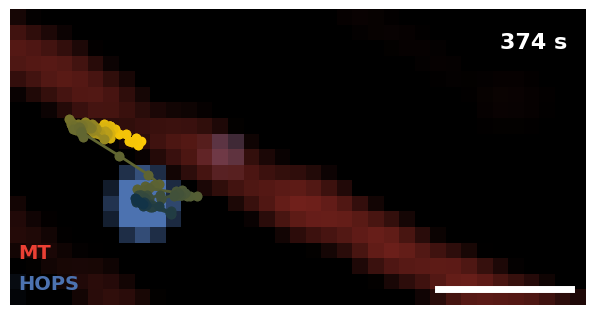

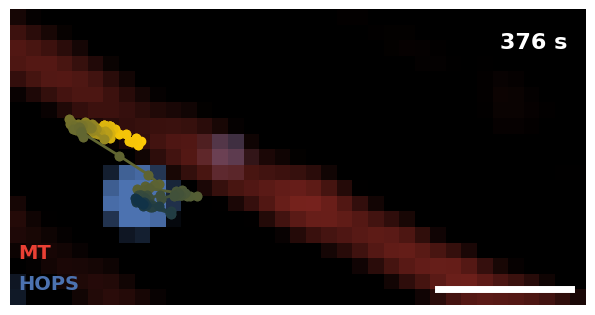

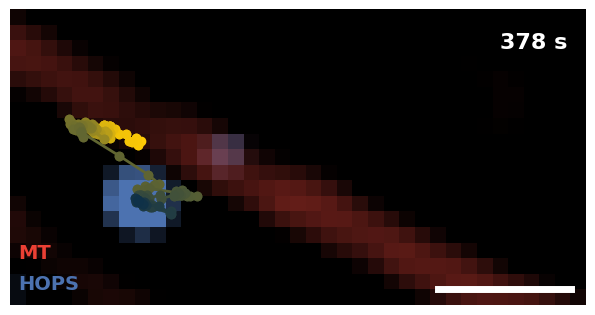

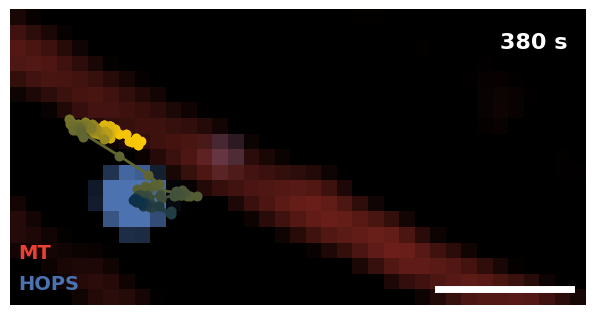

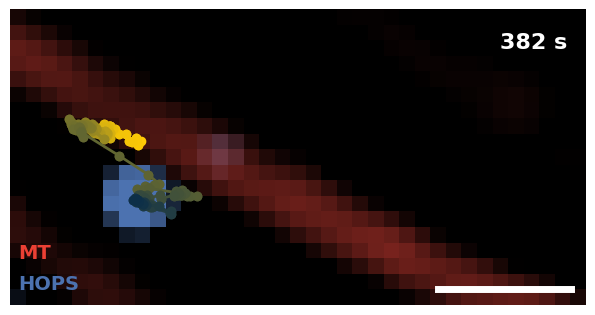

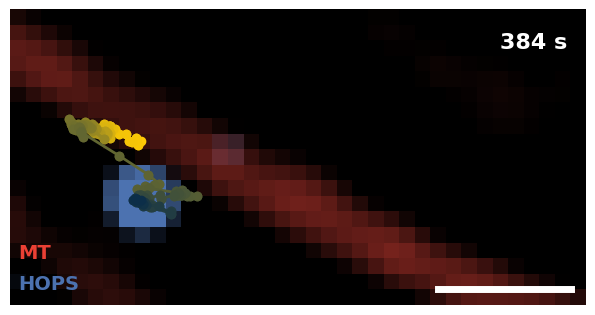

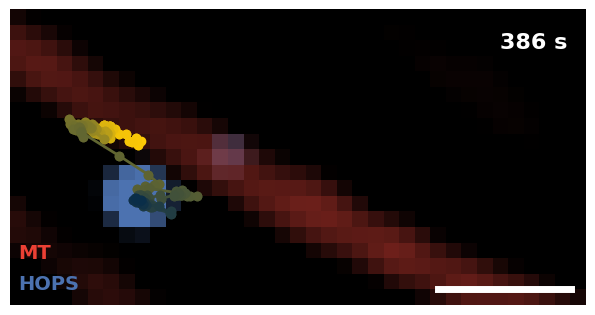

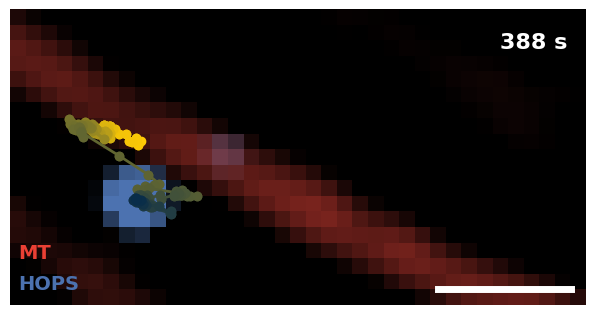

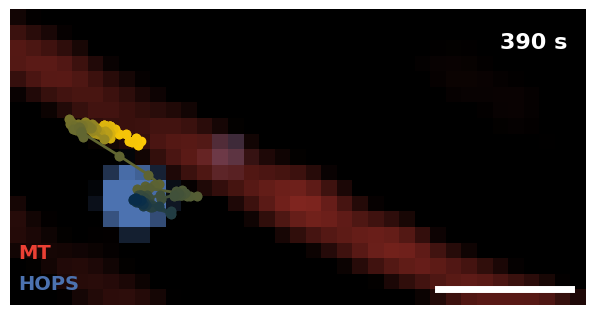

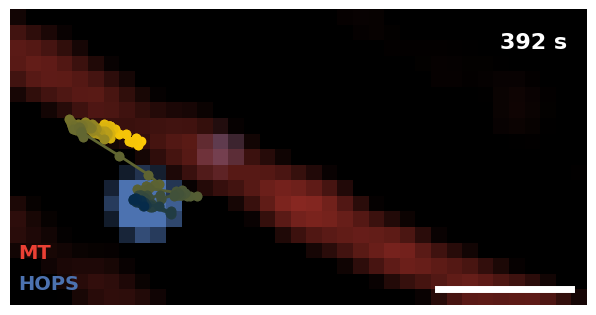

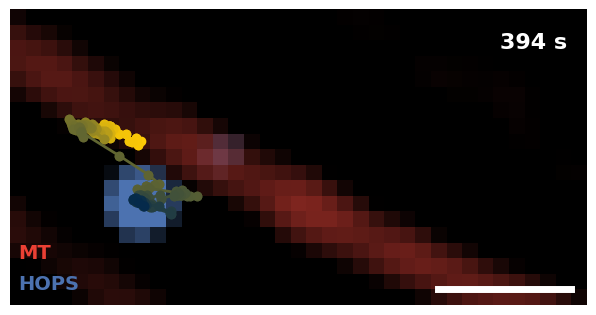

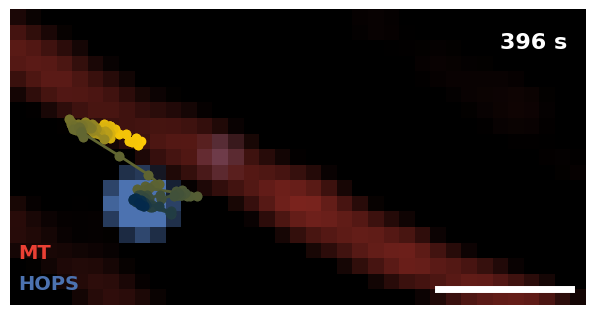

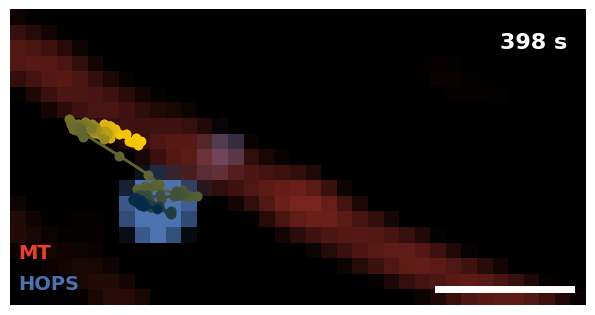

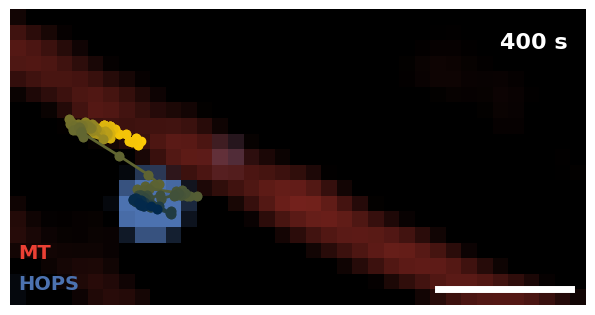

In [3]:
um_per_pixel = 0.117
s_per_frame = 2
folder_data = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\HOPS_Microtubule_dual imaging_SiR_Tubulin\Analysed data\For_montage"
folder_save = folder_data

tif_filename = "C1_C2_Merged_20241031_UGD_HOPS_MT_SiR-Tubulin_2x_exp500ms_rep3_FOV-2-right-bandpass.tif"
csv_filename = "20241031_UGD_HOPS_MT_SiR-Tubulin_2x_rep3_FOV-2-right-wstepflags.csv"

os.chdir(folder_data)
video = imread(tif_filename)
print("Shape of video array:", video.shape)
df = pd.read_csv(csv_filename)
df = df.sort_values("t")

plow = 0.5  # imshow intensity percentile
phigh = 90
scalebar_color = "white"

cmap_blue = clr.LinearSegmentedColormap.from_list(
    "dark2blue",
    ["black", "#4C72B0"],
)
cmap_red = clr.LinearSegmentedColormap.from_list(
    "transparent2red",
    [(0.753, 0.22, 0.188, 0), (0.753, 0.22, 0.188, 1)],
)
N = df.shape[0]
cmap = clr.LinearSegmentedColormap.from_list("maize2blue", ["#FFCB05", "#00274C"], N=N)

scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um / um_per_pixel
scale_bar_offset = 1
fig, ax = plt.subplots(1, 1)
all_avaliable_frames = set(df["t"].unique())


def animate(frame):
    ax.clear()
    img_red = video[frame - 1, 0, :, :]
    img_blue = video[frame - 1, 1, :, :]
    plt.imshow(
        img_blue,
        cmap=cmap_blue,
        vmin=20,
        vmax=60,
        # origin='upper'
    )
    plt.imshow(
        img_red,
        cmap=cmap_red,
        vmin=20000,
        vmax=52000,
        # origin='upper'
    )
    # add time stamp
    plt.text(
        31,
        2,
        str(round(frame * s_per_frame, 2)) + " s",
        color="white",
        weight="bold",
        size=16,
    )
    # add color labels
    plt.text(
        0,
        15.5,
        "MT",
        color="#eb4034",
        weight="bold",
        size=14,
    )
    plt.text(
        0,
        17.5,
        "HOPS",
        color="#4C72B0",
        weight="bold",
        size=14,
    )

    # Add a single current circle, except for gaps
    if frame - 1 in all_avaliable_frames:
        current_x = df[df["t"] == frame - 1]["x"].squeeze()
        current_y = df[df["t"] == frame - 1]["y"].squeeze()
        c = plt.Circle(
            (current_x, current_y),
            1.3,
            color="white",
            fill=False,
            lw=2,
        )
        ax.add_patch(c)
    # Add a single track
    track = df[df["t"] <= frame - 1]
    t_plot = track["t"].to_numpy(float)
    x_plot = track["x"].to_numpy(float)
    y_plot = track["y"].to_numpy(float)
    for i in range(len(t_plot) - 1):
        plt.plot(
            x_plot[i : i + 2],
            y_plot[i : i + 2],
            "-o",
            color=cmap(i / N),
            lw=2,
        )
    # scale bar
    scale_bar_offset = 0
    scalebar_length_um = 1
    base_x = 27
    base_y = 17.5
    scalebar_length_pxl = scalebar_length_um / um_per_pixel
    plt.plot(
        [
            base_x + scale_bar_offset,
            base_x + scale_bar_offset + scalebar_length_pxl,
        ],
        [base_y + scale_bar_offset, base_y + scale_bar_offset],
        "-",
        color="white",
        lw=5,
    )
    plt.xlim(0, img_blue.shape[0])
    plt.ylim(img_blue.shape[1], 0)
    # ax.invert_yaxis()
    plt.tight_layout()
    plt.axis("scaled")
    plt.axis("off")

# animate(5)
# ani = FuncAnimation(fig, animate, frames=150, interval=20, repeat=False)
# writer = animation.FFMpegWriter(fps=25)  # 25 Hz, 0.5x playback (original:50Hz)
# ani.save(join(folder_save, "VideoS_RNA_escape.mp4"), writer=writer, dpi=600)

# Create montage images
num_frames = 200
for frame in range(1,num_frames+1):
    animate(frame)
    plt.savefig(join(folder_save, f"frame_{frame:03d}.png"), dpi = 600)
    plt.show()

plt.close(fig)

#Create animated video
# ani = FuncAnimation(fig, animate, frames=200, interval=20, repeat=False)
# writer = animation.FFMpegWriter(fps=20)  # 20 Hz
# ani.save(join(folder_save, "VideoS_HOPS_hopping_MT.mp4"), writer=writer, dpi=600)
